# 0.0. IMPORTS

In [112]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from boruta import BorutaPy
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
import pickle

import warnings
warnings.filterwarnings('ignore')

## 0.1. Functions

In [113]:
#Time series cross-validation
def cross_validation(x_training, model, model_name, n_weeks, cv = 5, verbose = False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in range(cv, 0, -1):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #começo e fim da validação
        validation_start_date = x_training.date.max() - timedelta(days =k * n_weeks * 7)
        validation_end_date = x_training.date.max() - timedelta(days =(k -1) * n_weeks * 7)

        #filtering
        training = x_training[x_training.date < validation_start_date]
        validation = x_training[(x_training.date >= validation_start_date) & (x_training.date <= validation_end_date)]

        #training and validation set
        xtraining = training.drop(columns=['date', 'sales'])
        ytraining = training['sales']

        xvalidation = validation.drop(columns=['date', 'sales'])
        yvalidation = validation['sales']

        #model
        m = model
        m.fit(xtraining, ytraining)

        #predict
        yhat = m.predict(xvalidation)

        #performance
        result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store scores
        mae_list.append(result.MAE[0])
        mape_list.append(result.MAPE[0])
        rmse_list.append(result.RMSE[0])


    return pd.DataFrame({'Model Name': model_name,
                         'MAE_mean': np.average(mae_list),
                         'MAE_std': np.std(mae_list),
                         'MAPE_mean': np.average(mape_list),
                         'MAPE_std': np.std(mape_list),
                         'RMSE_mean': np.average(rmse_list),
                         'RMSE_std': np.std(rmse_list)}, index=[0])

#MPE
def mean_percentage_error(y, yhat):
    return np.mean( (y - yhat)/y )


#calcula os erros de um modelo
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def v_cramer(x, y):

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    chi2 = stats.chi2_contingency( cm )[0]
    phi2 = chi2/n
    
    
    phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    k_corr = k - np.square(k-1) / (n-1)
    r_corr = r - np.square(r-1) / (n-1)
    
    return np.sqrt( (phi2_corr)/(min(k_corr-1, r_corr-1)) )

def get_cramer_df(df):
    cols = cat_attributes.columns
    cramer_dic = {}
    for col1 in cols:
        cramer_list = []
        for col2 in cols:
            v = v_cramer(cat_attributes[col1], cat_attributes[col2])
            cramer_list.append(v)

        cramer_dic[col1] = cramer_list

    df_cramer = pd.DataFrame(cramer_dic)
    df_cramer.index = cols
    
    return df_cramer

## 0.2. Loading Data

In [114]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [115]:
df_store_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


# 1.0. DESCRICAO DOS DADOS

## 1.1. Renomear Colunas

In [116]:
#copia tabela
df1 = df_raw.copy()

In [117]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [118]:
#renomeia as colunas para snakecase
cols = df1.columns.to_list()
snakecase = lambda x: inflection.underscore(x)
cols = list(map(snakecase, cols))

df1.columns = cols

## 1.2. Dimensões da tabela

In [119]:
print(f'Number of rows: {df1.shape[0]}\nNumber of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3. Tipos de dados

In [120]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [121]:
#converte coluna date para o tipo datetime
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Checa NAs

In [122]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Preenche NAs

In [123]:
# competition_distance
df1.loc[df1['competition_distance'].isna() == True, 'competition_distance'] = 200000

# competition_open_since_month
df1.loc[df1['competition_open_since_month'].isna() == True, 'competition_open_since_month'] = df1['date'].dt.month

# competition_open_since_year
df1.loc[df1['competition_open_since_year'].isna() == True, 'competition_open_since_year'] = df1['date'].dt.year

# promo2_since_week
df1.loc[df1['promo2_since_week'].isna() == True, 'promo2_since_week'] = df1['date'].dt.isocalendar().week

# promo2_since_year
df1.loc[df1['promo2_since_year'].isna() == True, 'promo2_since_year'] = df1['date'].dt.year

# promo_interval
month_map = {1: 'Jan',
             2: 'Feb',
             3: 'Mar',
             4: 'Apr',
             5: 'May',
             6: 'Jun',
             7: 'Jul',
             8: 'Aug',
             9: 'Sept',
             10: 'Oct',
             11: 'Nov',
             12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 or
                                            x['month_map'] not in x['promo_interval'].split(',') else 1, axis=1)

## 1.6. Mudando tipo dos dados

In [124]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int')

## 1.7. Estatística descritiva

In [125]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

## 1.7.1. Atributos Numericos

In [126]:
# Tendencia Central - Media, mediana
# Dispercao - std, min, max, range, skew, kurtosis

m = pd.DataFrame(num_attributes.agg([np.min, np.max, lambda x: x.max() - x.min(), np.mean,
                                     np.median, np.std, lambda x: x.skew(), 
                                     lambda x: x.kurtosis()])).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis' ]
m

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


## 1.7.2 Atributos categoricos

In [127]:
cat_attributes.apply(lambda x : len(x.unique()))

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

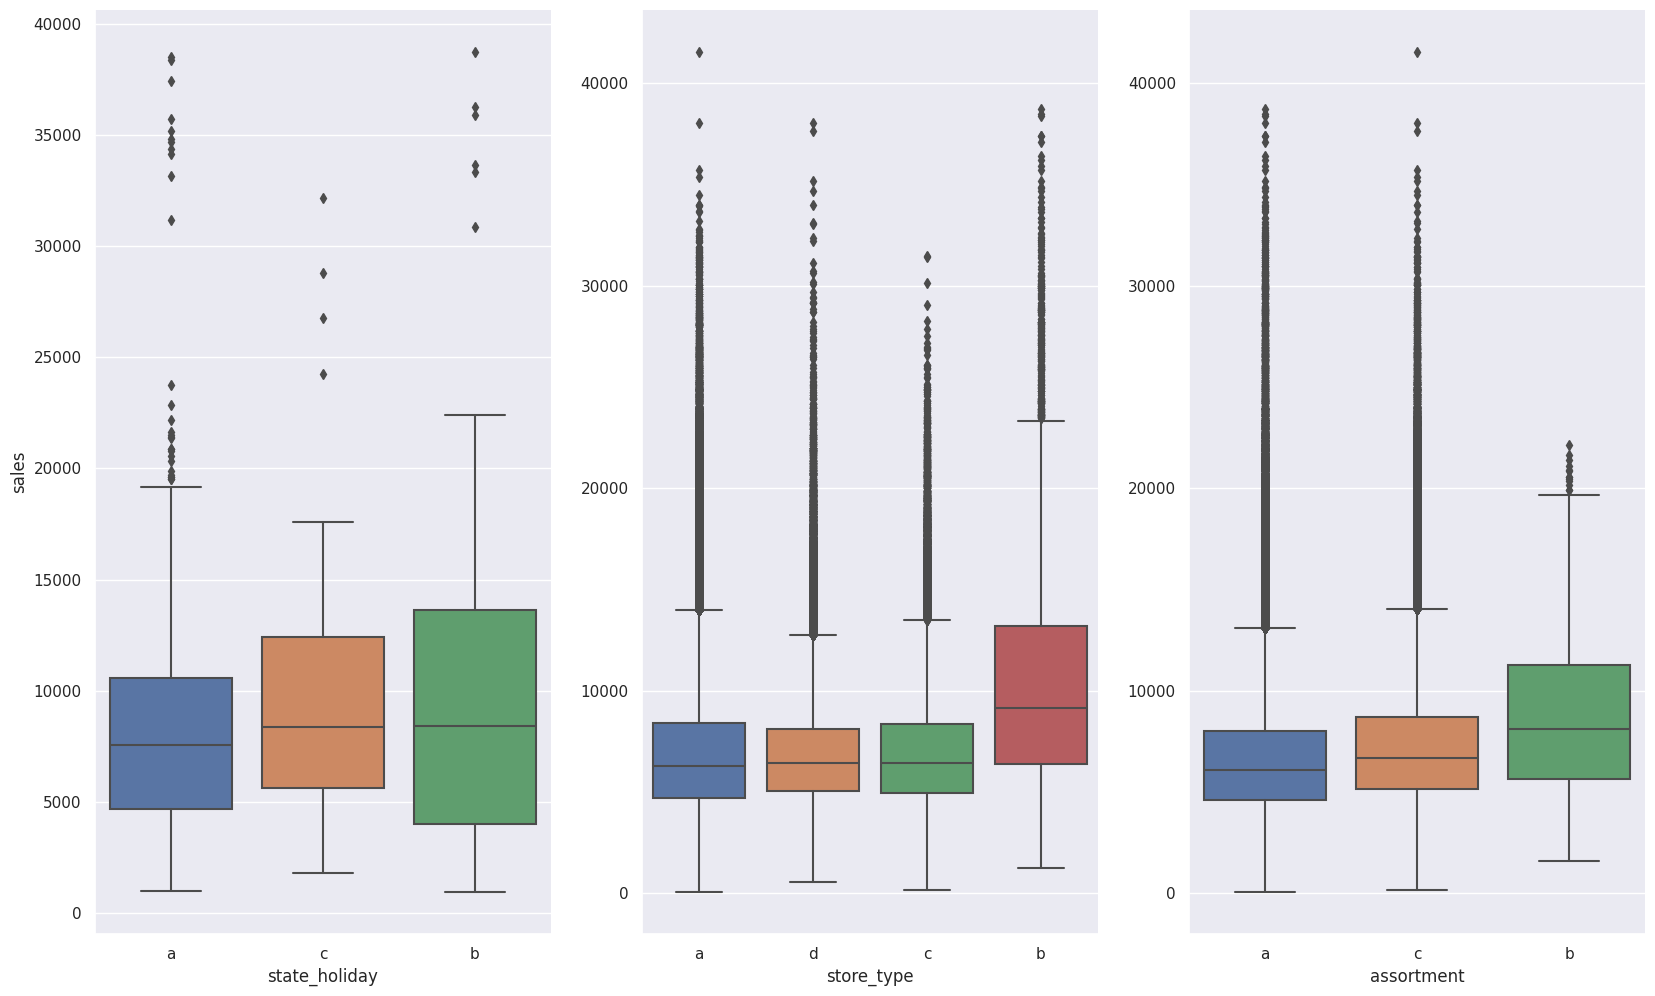

In [128]:
df1_filtered = df1.loc[(df1['sales'] > 0)]
# cols = ['state_holiday', 'store_type', 'assortment']
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,12))

sns.boxplot(data = df1.loc[(df1['state_holiday'] != '0') & (df1['sales'] > 0)], 
            x = 'state_holiday', y = 'sales', 
            ax = axes[0],
            order=df1.loc[(df1['state_holiday'] != '0') & (df1['sales'] > 0)].groupby('state_holiday').median()['sales'].sort_values().index)

sns.boxplot(data = df1.loc[(df1['sales'] > 0)], 
            x = 'store_type', y = 'sales', 
            ax = axes[1],
            order=df1.loc[(df1['sales'] > 0)].groupby('store_type').median()['sales'].sort_values().index).set(ylabel = '')

sns.boxplot(data = df1.loc[(df1['sales'] > 0)], 
            x = 'assortment', y = 'sales', 
            ax = axes[2],
            order=df1.loc[(df1['sales'] > 0)].groupby('assortment').median()['sales'].sort_values().index).set(ylabel = '')

sns.despine()

# 2.0 FEATURE ENGINEERING

In [129]:
df2 = df1.copy()

## 2.1. Mapa mental de hipoteses

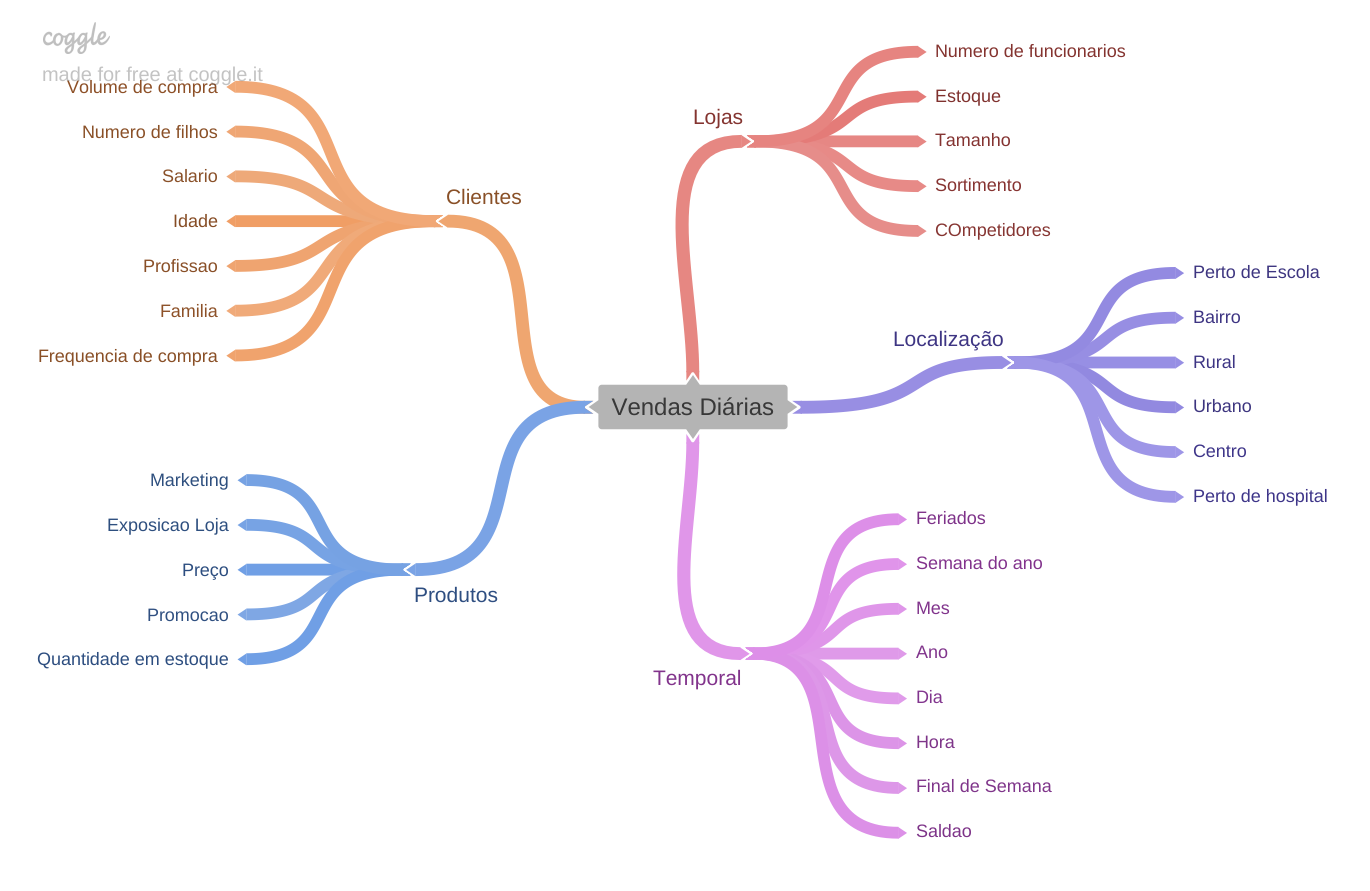

In [130]:
Image('img/mindmap_hypothesis.png')

## 2.1. Criação de hipoteses

### 2.1.1. Hipoteses loja

1. Lojas com número maior de funcionários deveriam vender mais, em média.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos, em média.
6. Lojas com competidores a mais tempo deveriam vendem mais, em média.

### 2.1.2. Hipoteses dos produtos

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipoteses Tempo


1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista final de hipóteses

1. Lojas com maior sortimentos deveriam vender mais, em média.
2. Lojas com competidores mais próximos deveriam vender menos, em média.
3. Lojas com competidores à mais tempo deveriam vendem mais, em média
4. Lojas com promoções ativas por mais tempo deveriam vender mais, em média
5. Lojas com mais dias de promoção deveriam vender mais, em média
6. Lojas com mais promoções consecutivas deveriam vender mais, em média
7. Lojas abertas durante o feriado de Natal deveriam vender mais, em média
8. Lojas deveriam vender mais ao longo dos anos, em média
9. Lojas deveriam vender mais no segundo semestre do ano, , em média
10. Lojas deveriam vender mais depois do dia 15 de cada mês, em média.
11. Lojas deveriam vender menos aos finais de semana, em média
12. Lojas deveriam vender menos durante os feriados escolares, em média

## 2.3. Feature Engineering

In [131]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.strftime('%U')
df2['week_of_year'] = df2['week_of_year'].astype(int)

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%U')

#competition since
df2['competition_since'] = df2.apply(lambda x : datetime(year = x['competition_open_since_year'],
                                                         month = x['competition_open_since_month'],
                                                         day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

#assortment

df2.loc[df2['assortment'] == 'a', 'assortment'] = 'basic'
df2.loc[df2['assortment'] == 'b', 'assortment'] = 'extra'
df2.loc[df2['assortment'] == 'c', 'assortment'] = 'extended'

#state holiday

df2.loc[df2['state_holiday'] == 'a', 'state_holiday'] = 'public_holiday'
df2.loc[df2['state_holiday'] == 'b', 'state_holiday'] = 'easter_holiday'
df2.loc[df2['state_holiday'] == 'c', 'state_holiday'] = 'christmas'
df2.loc[df2['state_holiday'] == '0', 'state_holiday'] = 'regular_day'

# 3.0. FILTRAGEM DE VARIÁVEIS (RESTRIÇÃO DE NEGÓCIO)

In [132]:
df3 = df2.copy()

## 3.1. Filtragem das linhas

In [133]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtragem das colunas

In [134]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(columns=cols_drop)

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS

## 4.1. Análise Univariada

### Responsive Variable

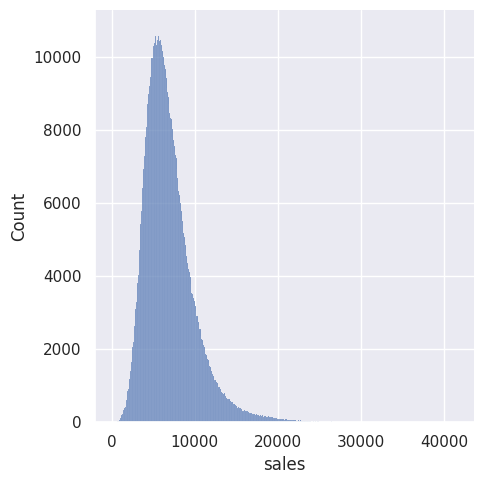

In [136]:
sns.displot(df4['sales'])

### Numerical Variable

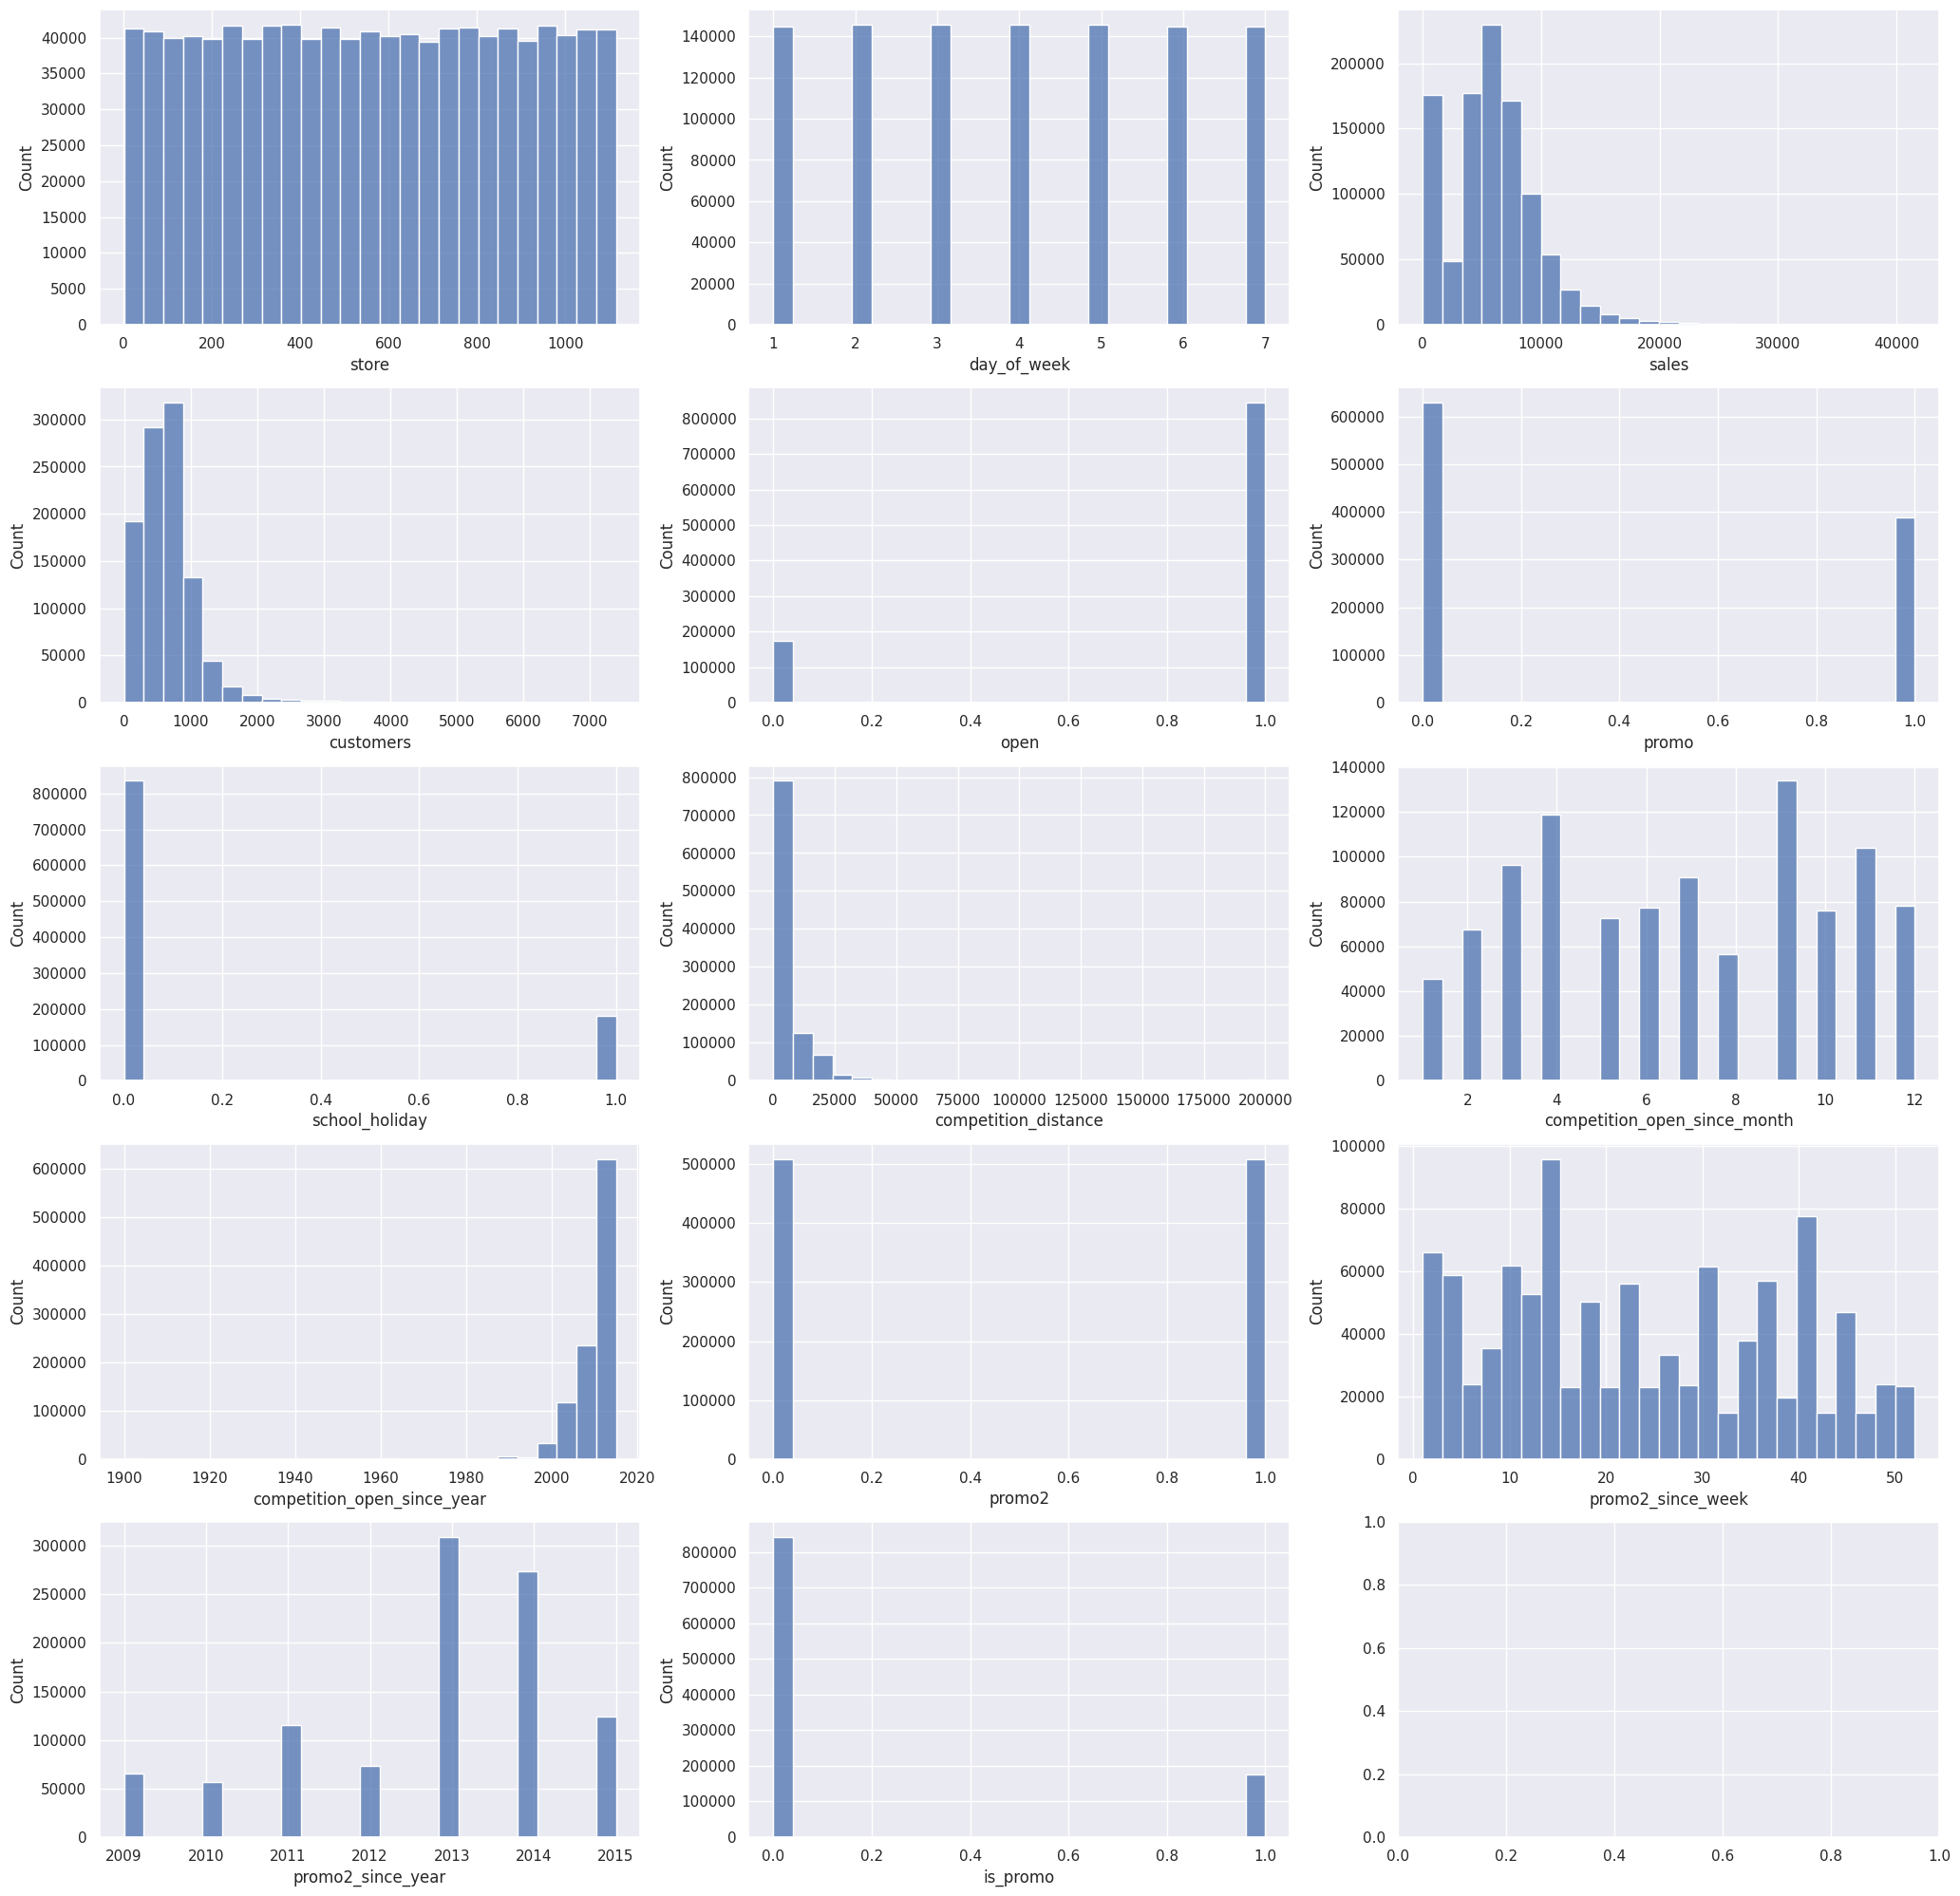

In [137]:
fig, axes = plt.subplots(5, 3, figsize=(25,25))
axes = axes.flatten()

for i, col in enumerate(num_attributes.columns):
    sns.histplot(data = num_attributes, 
                 x = col, 
                 bins=25,
                 ax=axes[i])

plt.show()

### Categorical Variable

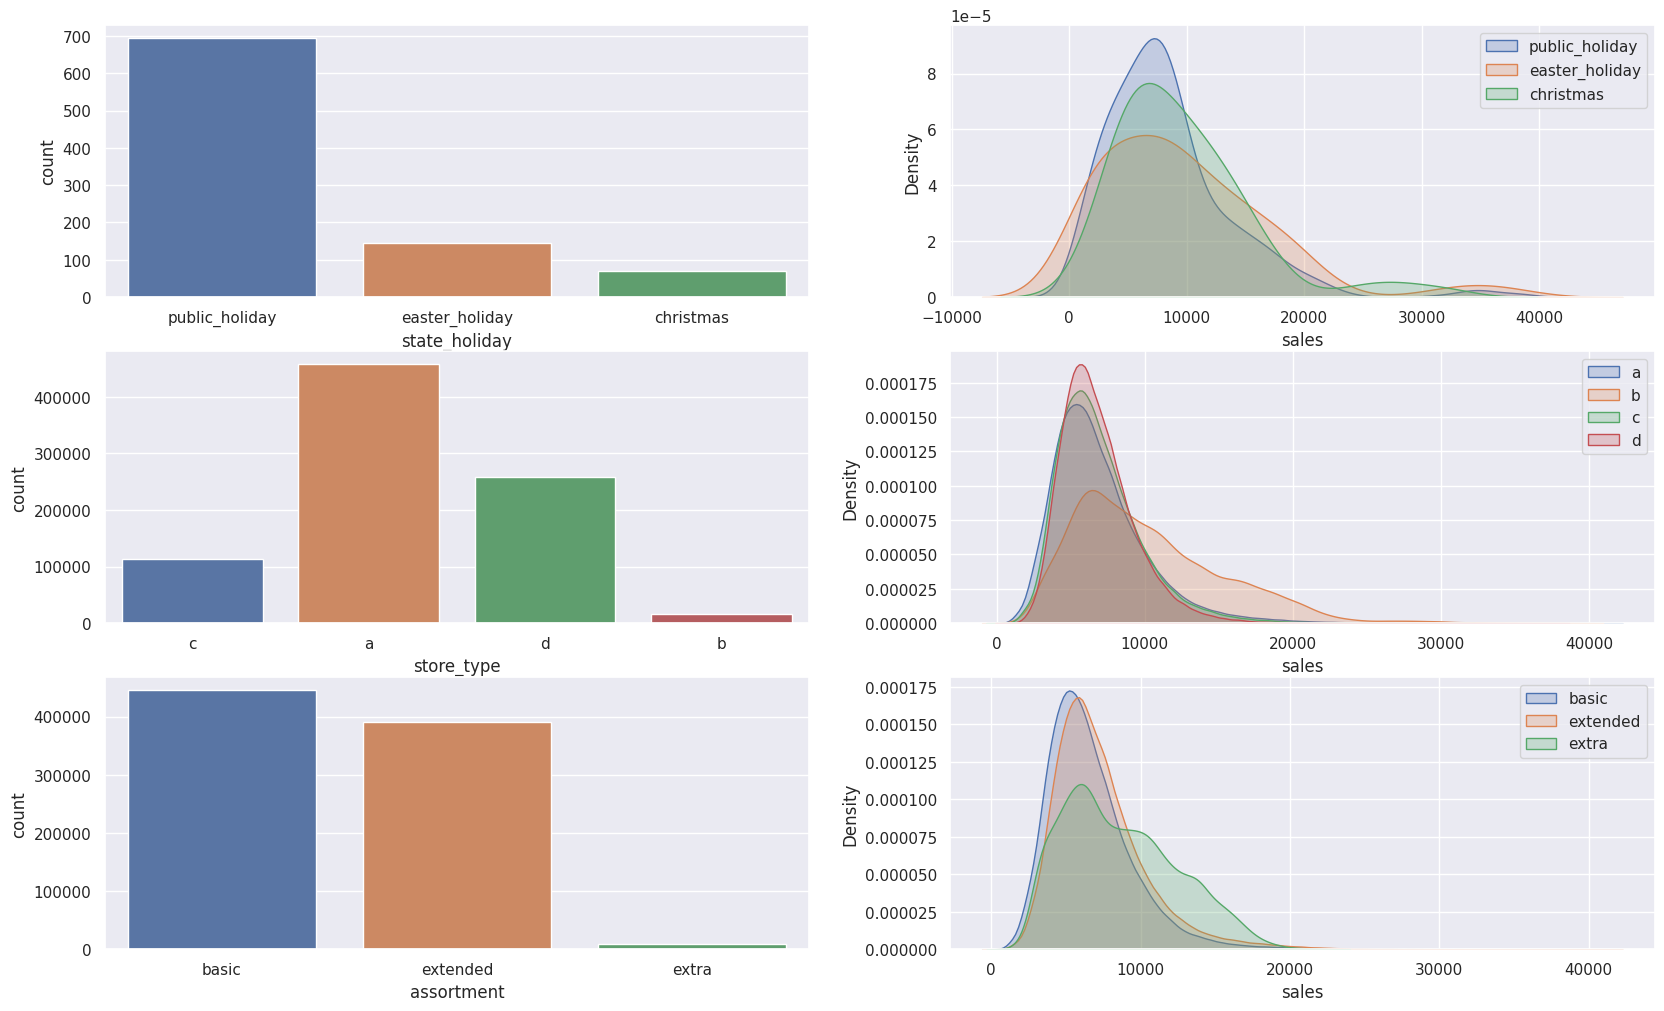

In [138]:
#state_holiday
plt.figure(figsize=(20,12))

plt.subplot(3,2,1)
sns.countplot(data= df4[df4['state_holiday'] != 'regular_day'], 
              x = 'state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(data=df4[df4['state_holiday'] == 'public_holiday']['sales'], 
            shade=True,
            label='public_holiday')

sns.kdeplot(data=df4[df4['state_holiday'] == 'easter_holiday']['sales'], 
            shade=True,
            label='easter_holiday')

sns.kdeplot(data=df4[df4['state_holiday'] == 'christmas']['sales'], 
            shade=True,
            label='christmas')

plt.legend()

#store_type
plt.subplot(3,2,3)
sns.countplot(data= df4, x = 'store_type')

plt.subplot(3,2,4)
sns.kdeplot(data=df4[df4['store_type'] == 'a']['sales'], 
            shade=True,
            label='a')

sns.kdeplot(data=df4[df4['store_type'] == 'b']['sales'], 
            shade=True,
            label='b')

sns.kdeplot(data=df4[df4['store_type'] == 'c']['sales'], 
            shade=True,
            label='c')

sns.kdeplot(data=df4[df4['store_type'] == 'd']['sales'], 
            shade=True,
            label='d')
plt.legend()

#assortment
plt.subplot(3,2,5)
sns.countplot(data= df4, x = 'assortment')

plt.subplot(3,2,6)
sns.kdeplot(data=df4[df4['assortment'] == 'basic']['sales'], 
            shade=True,
            label='basic')

sns.kdeplot(data=df4[df4['assortment'] == 'extended']['sales'], 
            shade=True,
            label='extended')

sns.kdeplot(data=df4[df4['assortment'] == 'extra']['sales'], 
            shade=True,
            label='extra')

plt.legend();

## 4.2. Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais, em média.
***VERDADEIRO*** Lojas com maior sortimento vendem mais, em média

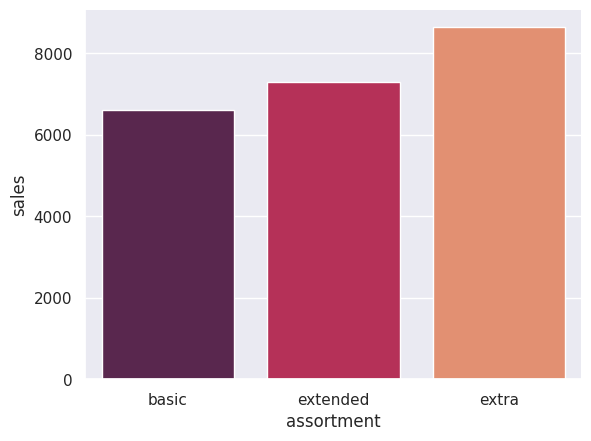

<Figure size 2000x1200 with 0 Axes>

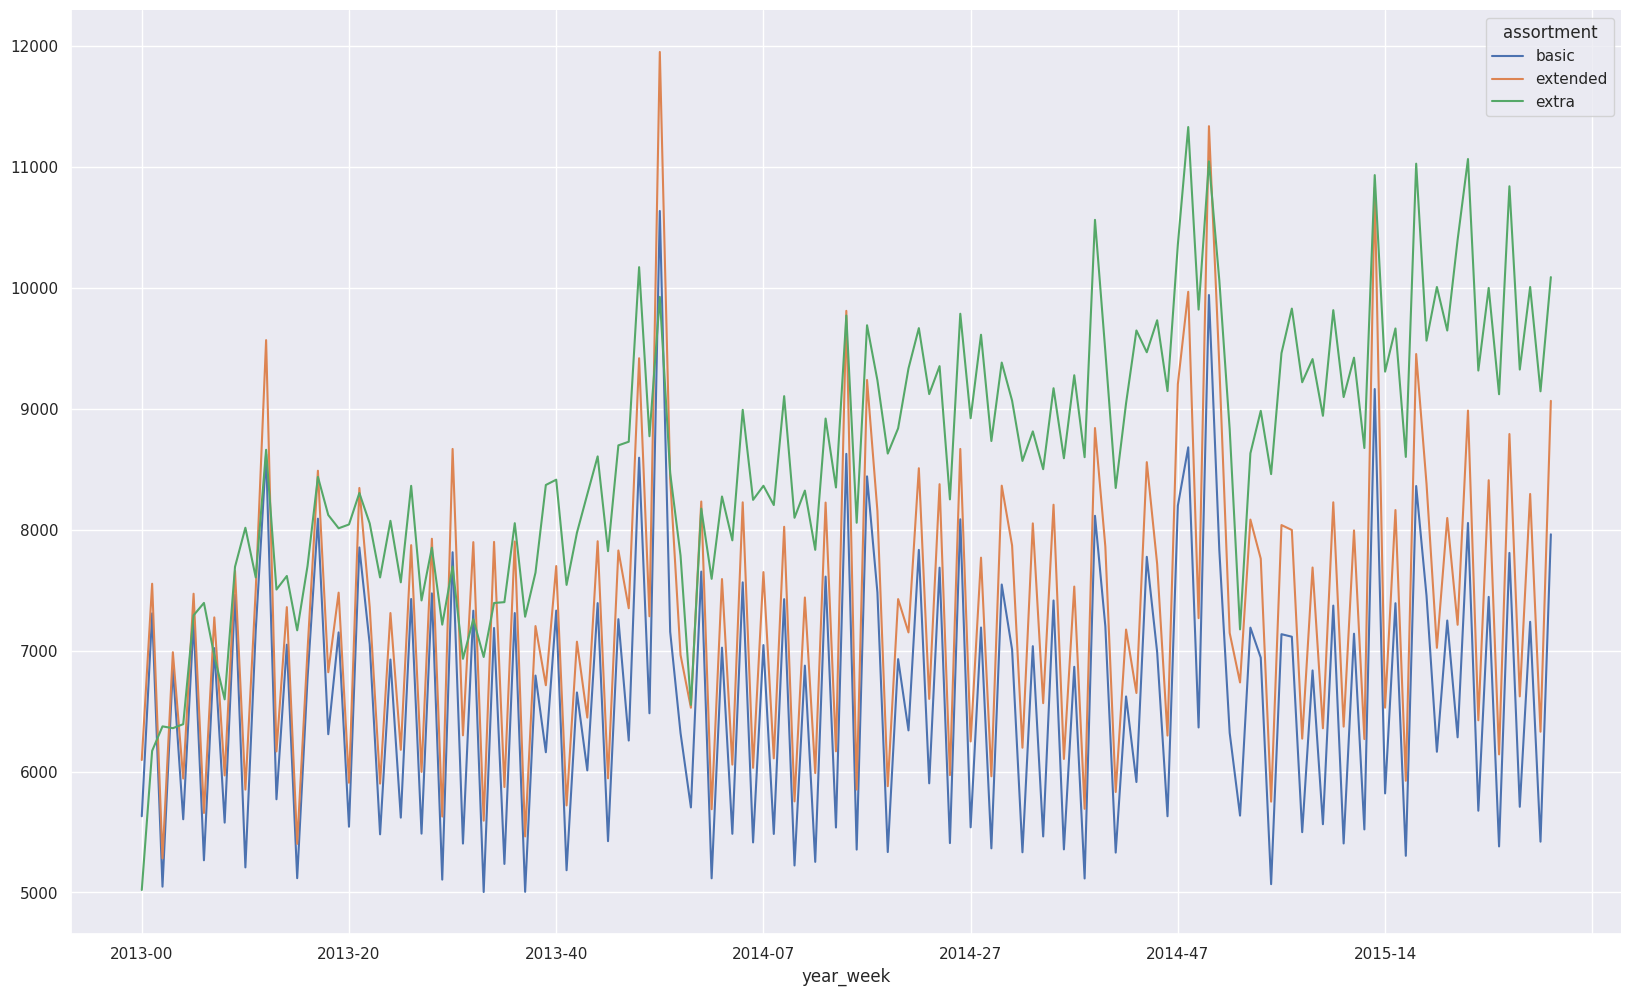

In [139]:
#first plot
aux1 = df4.groupby('assortment').mean()['sales'].reset_index()
sns.barplot(data= aux1, x = 'assortment', y='sales',
            palette='rocket')
sns.despine();


#second plot
plt.figure(figsize=(20,12))
aux2 = df4.groupby(['year_week', 'assortment']).mean()['sales'].reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(20,12))

sns.despine()

### H2. Lojas com competidores mais próximos deveriam vender menos, em média.
***FALSO*** A distância entre competidores não aparenta ter relação com a média de vendas.

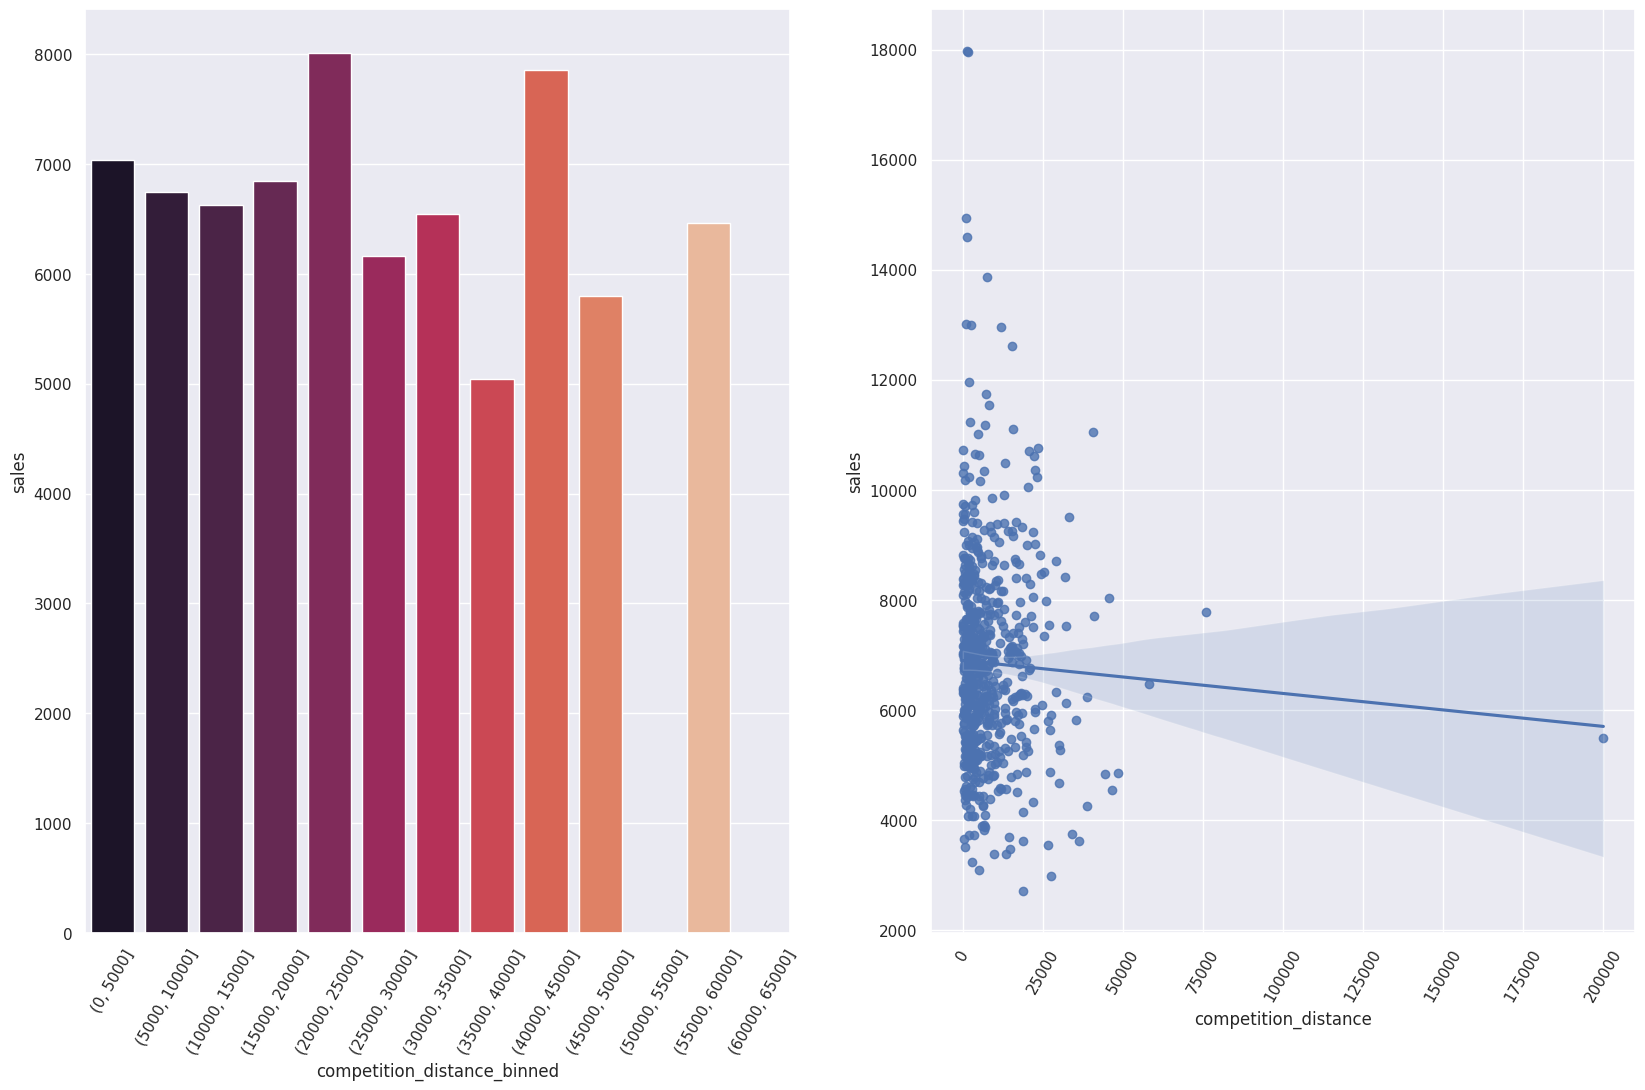

In [140]:
plt.figure(figsize=(20,12))

bins = np.arange(0,70000, 5000)
df4['competition_distance_binned'] = pd.cut(df4['competition_distance'], bins=bins)

aux1 = df4.groupby('competition_distance_binned').mean()[['sales']].reset_index()

#first plot
plt.subplot(1,2,1)
sns.barplot(data=aux1, x = 'competition_distance_binned', y = 'sales', palette='rocket')

plt.xticks(rotation=60)

#second plot
plt.subplot(1,2,2)
sns.regplot(data=df4.groupby('competition_distance').mean()[['sales']].reset_index(),
                x = 'competition_distance',
                y = 'sales')

plt.xticks(rotation=60);

### H3. Lojas com competidores a mais tempo deveriam vendem mais, em média.
***VERDADEIRO*** Lojas que têm um maior tempo de competição tendem a vender mais, em média.

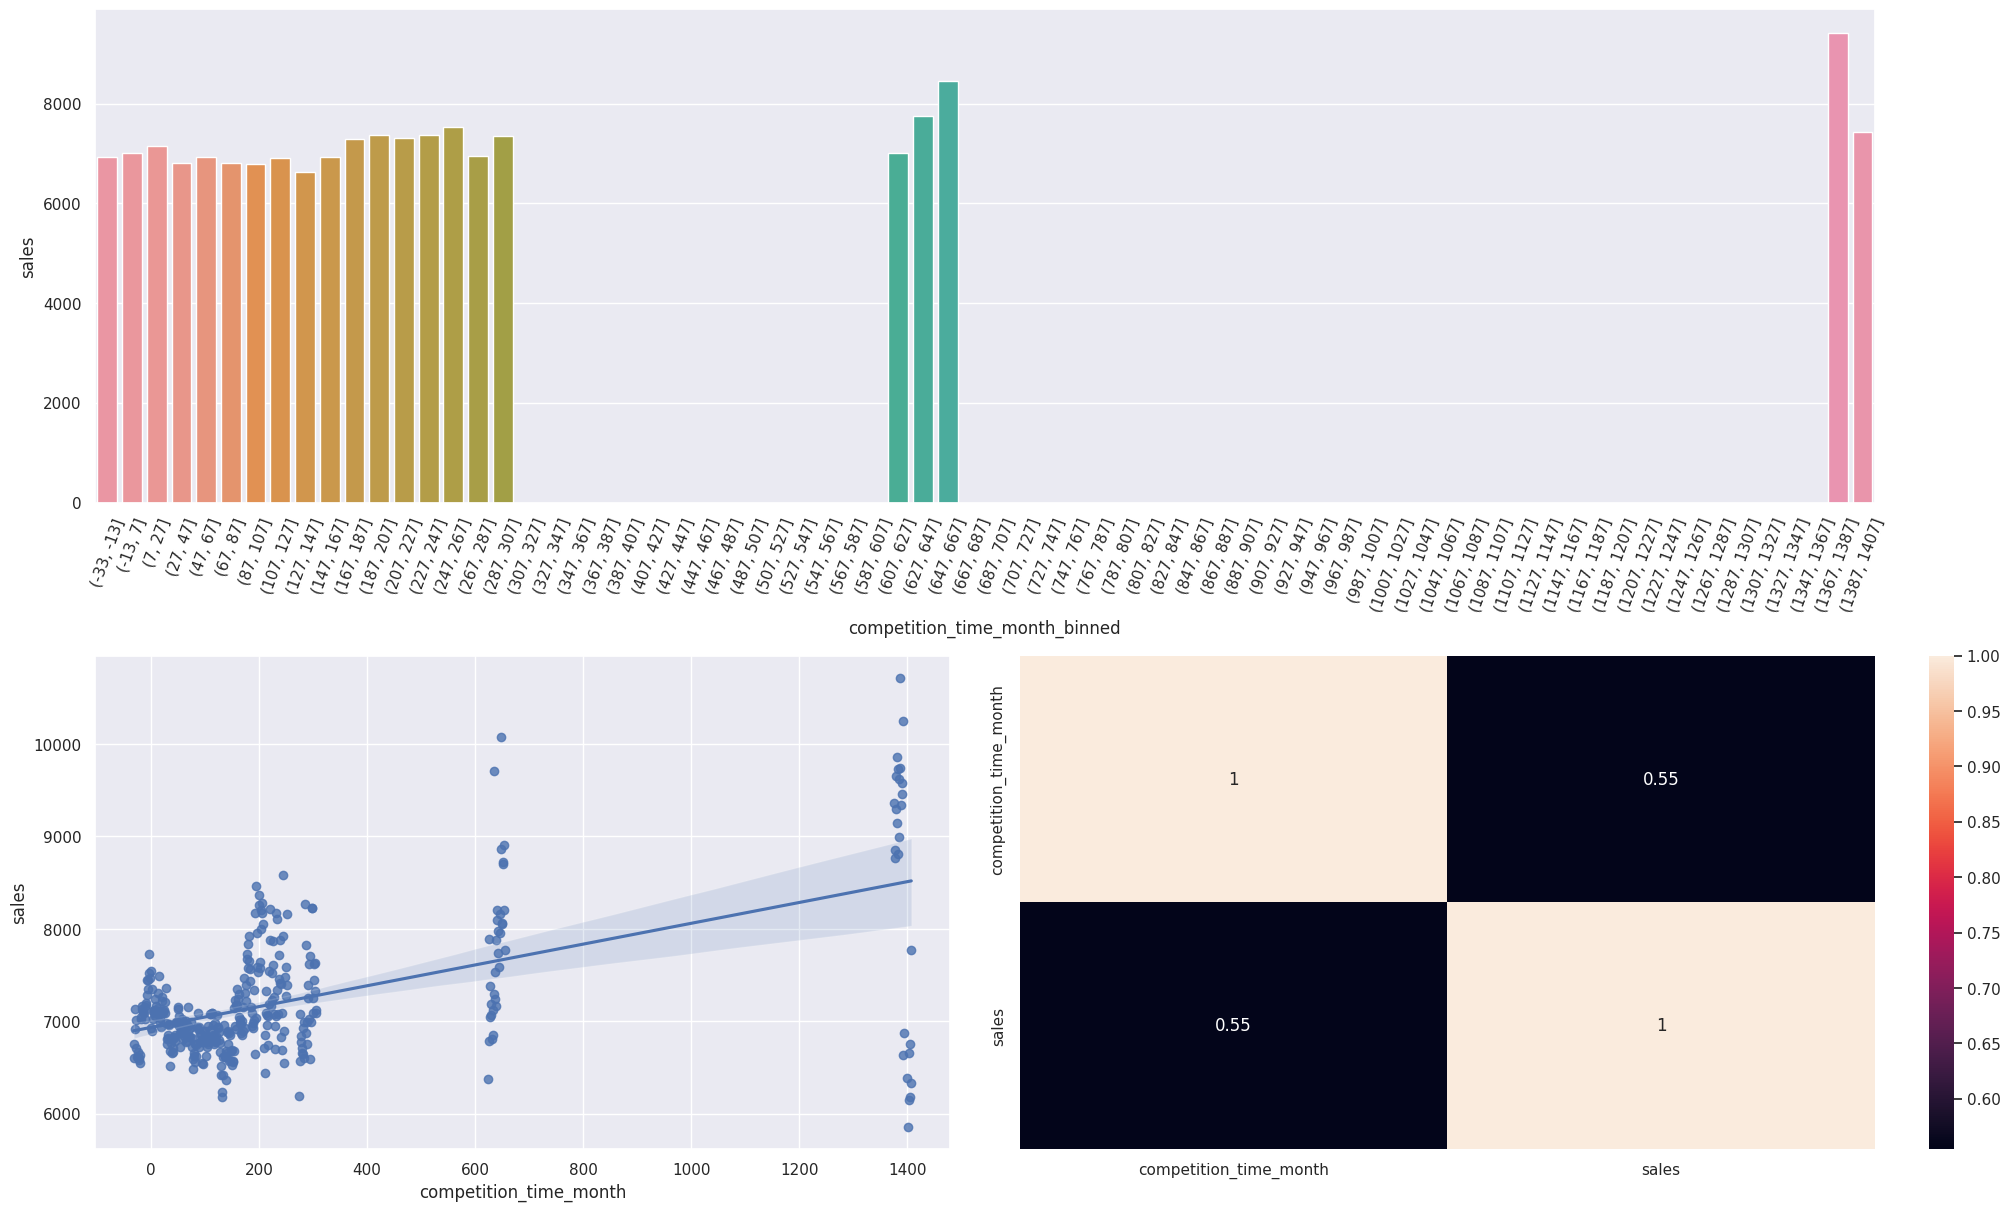

In [141]:
fig = plt.figure(figsize=(20,12), layout="constrained")
spec = fig.add_gridspec(2, 2)

bins = np.arange(df4['competition_time_month'].min() - 1 ,df4['competition_time_month'].max() + 1, 20)
df4['competition_time_month_binned'] = pd.cut(df4['competition_time_month'], bins=bins)

#first plot
ax0 = fig.add_subplot(spec[0, :])
aux1 = df4.groupby('competition_time_month_binned').mean()['sales'].reset_index()
sns.barplot(data=aux1, x = 'competition_time_month_binned', y = 'sales', ax=ax0)
plt.xticks(rotation=70)

#second plot
ax10 = fig.add_subplot(spec[1, 0])
aux2 = df4.groupby('competition_time_month').mean()['sales'].reset_index()

sns.regplot(data=aux2,
            x = 'competition_time_month', 
            y = 'sales',
            ax= ax10)

#third plot
ax11 = fig.add_subplot(spec[1, 1])
sns.heatmap(aux2.corr(method='pearson'), annot=True, ax=ax11);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais, em média.
***VERDADEIRO*** Lojas com promoções ativas por mais tempo tendem a vender mais, em média.

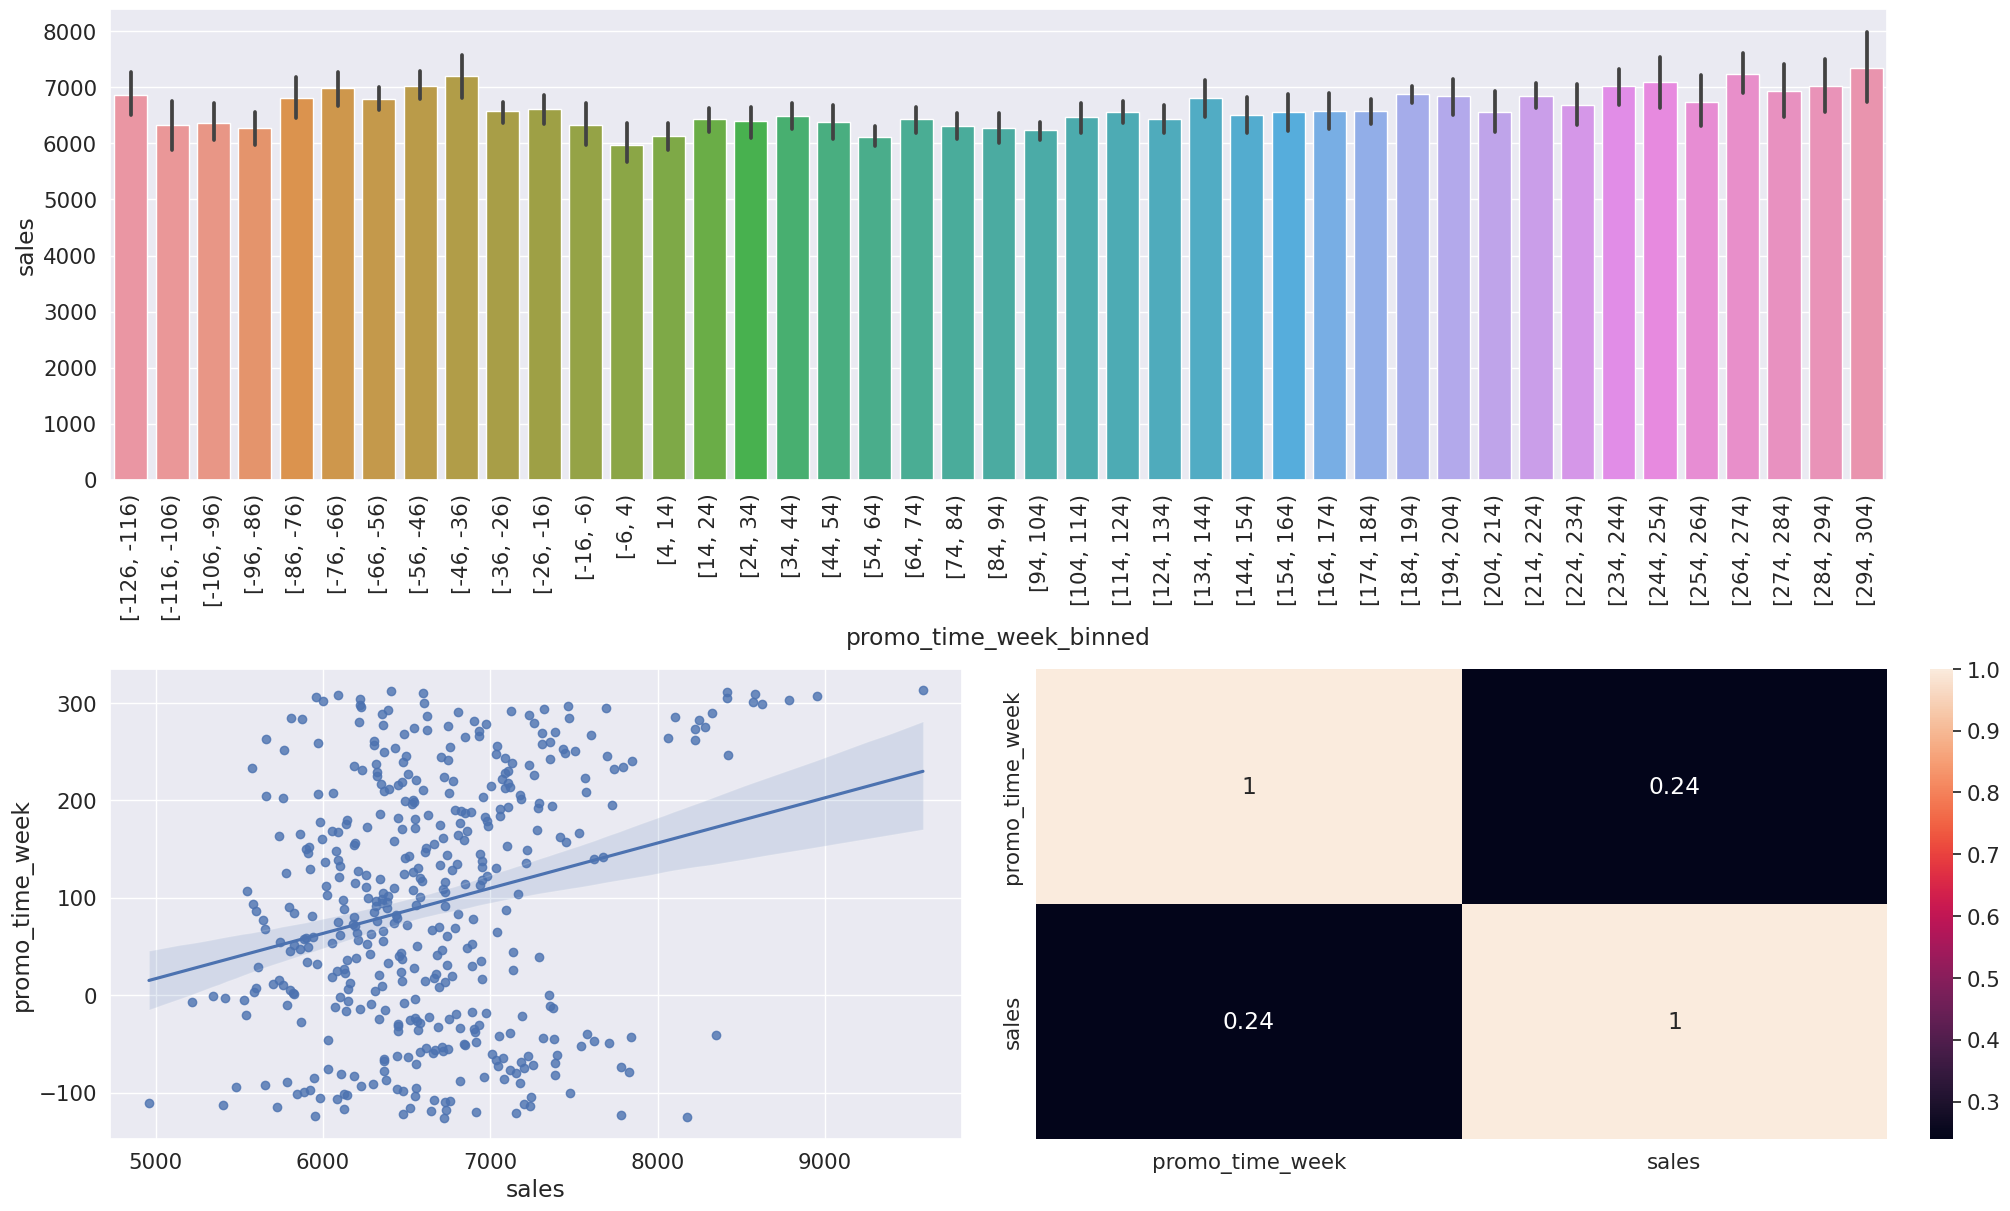

In [142]:
fig = plt.figure(figsize=(20,12), layout="constrained")
spec = fig.add_gridspec(2, 2)
sns.set(font_scale=1.4)

#first graph
ax0 = fig.add_subplot(spec[0, :])

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()
bins = np.arange(aux1['promo_time_week'].min(), aux1['promo_time_week'].max() + 1, 10)
aux1['promo_time_week_binned'] = pd.cut(aux1['promo_time_week'], bins=bins, right=False)

sns.barplot(data=aux1, x = 'promo_time_week_binned', y='sales', ax=ax0)
plt.xticks(rotation=90);

#second graph
ax10 = fig.add_subplot(spec[1, 0])

aux2 = df4[['sales', 'promo_time_week']].groupby('promo_time_week').mean().reset_index()
sns.regplot(data = aux2, x = 'sales', y = 'promo_time_week', ax=ax10)


#third plot
ax11 = fig.add_subplot(spec[1, 1])

sns.heatmap(aux2.corr(method='pearson'), annot=True, ax=ax11);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais, em média.
***FALSO*** Lojas com mais promoções consecutivas vendem menos

In [143]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,5529.566684
0,0,0,6328.187633
3,1,1,7836.672987
2,1,0,8618.452062


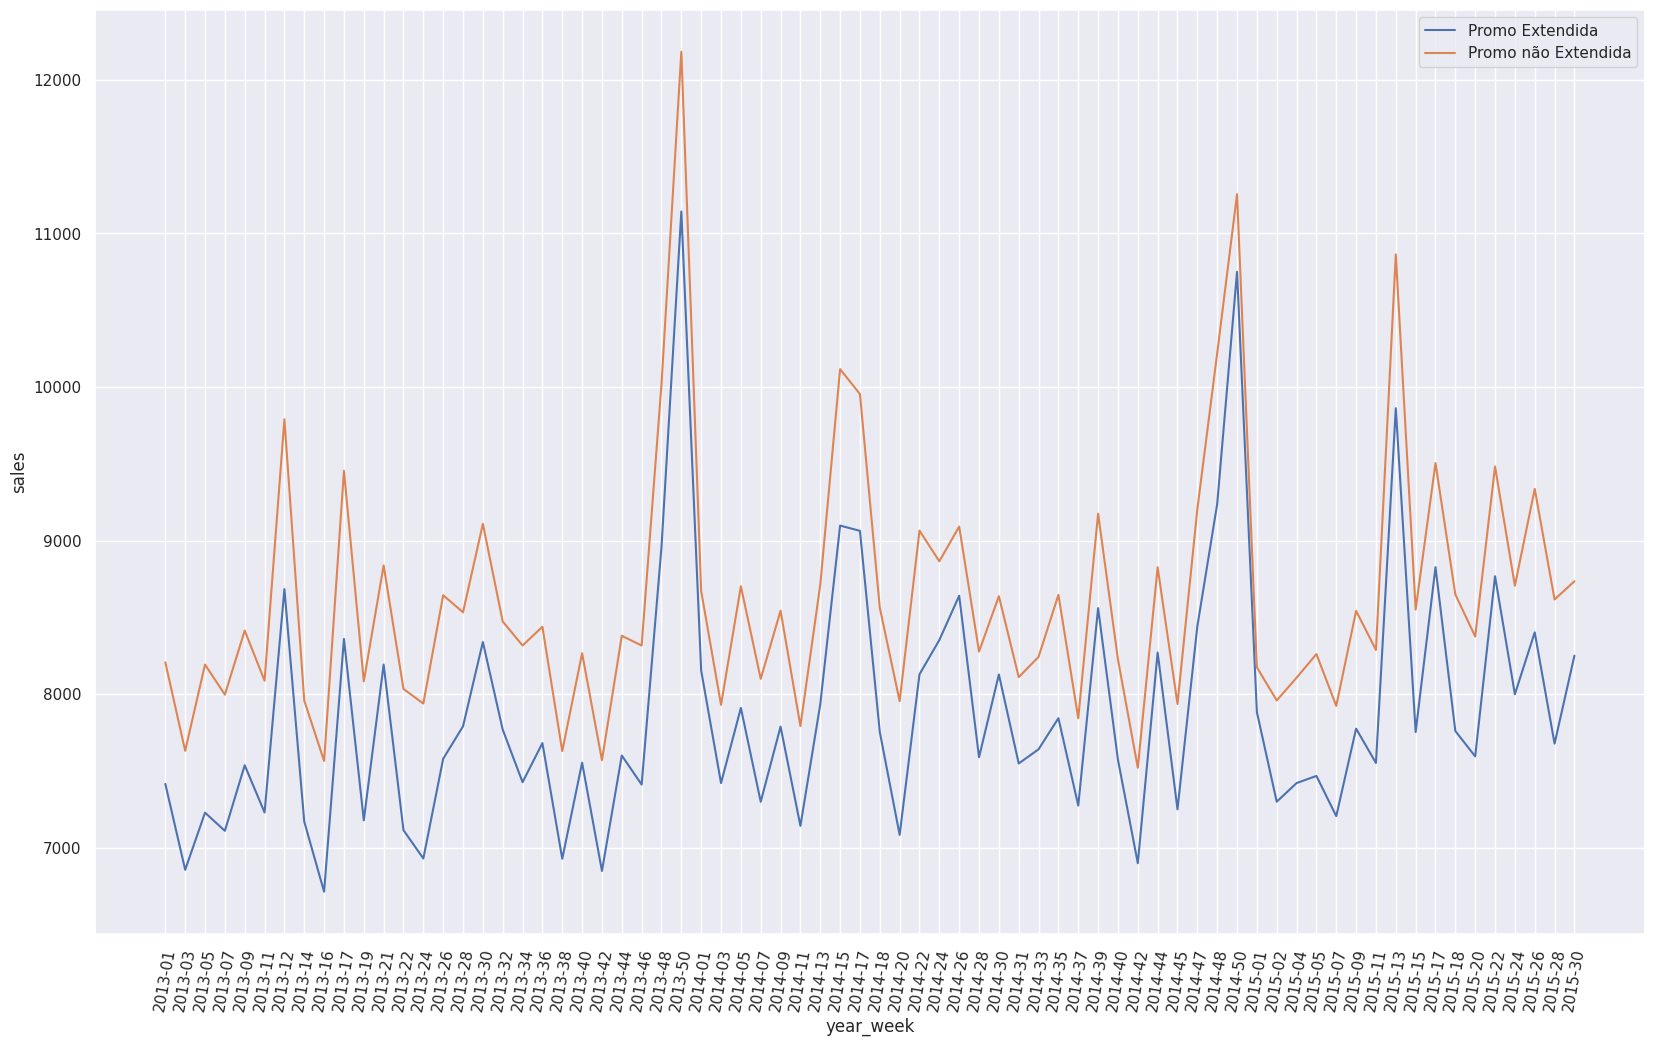

In [144]:
sns.set(font_scale = 1)
plt.figure(figsize=(20,12))


aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = sns.lineplot(data=aux1, x = 'year_week', y='sales', label='Promo Extendida')


aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
sns.lineplot(data=aux2, x = 'year_week', y='sales', ax=ax, label='Promo não Extendida')

plt.xticks(rotation = 80);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais, em média.
***VERDADEIRO*** Lojas abertas durante o feriado de Natal deveriam vender mais, em média. (Se possível observar por maiores períodos de tempo)

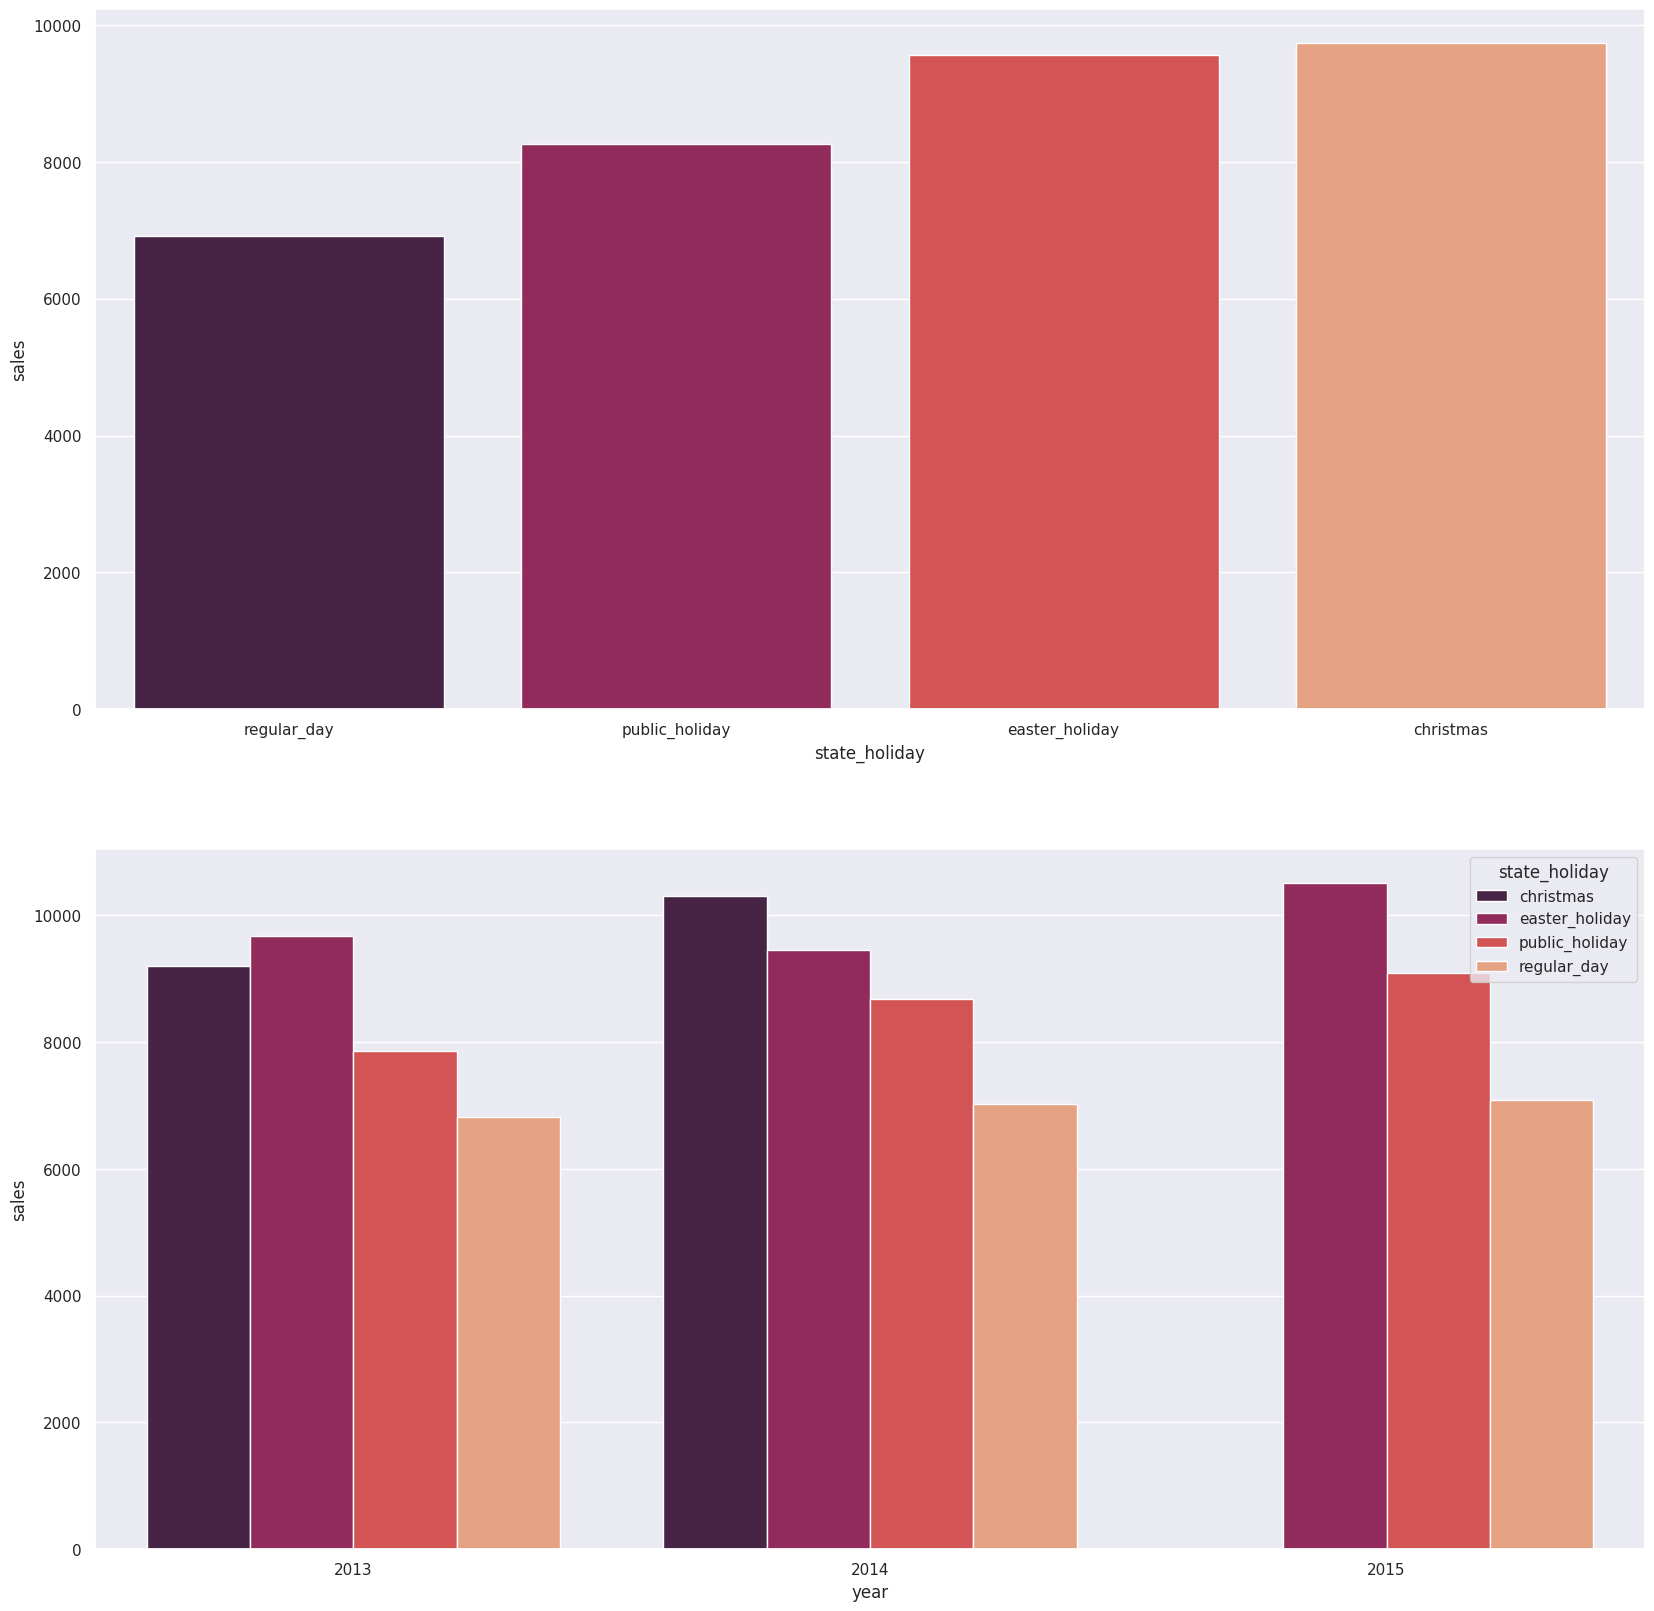

In [145]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
aux = df4[df4['year'] != 2015][['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index().sort_values(by='sales')
sns.barplot(x = 'state_holiday', y='sales', data=aux, palette='rocket')

plt.subplot(2,1,2)
aux1 = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(data = aux1, x = 'year', y = 'sales', hue='state_holiday', palette='rocket');

### H8. Lojas deveriam vender mais ao longo dos anos, em média.
***VERDADEIRO*** As vendas crescem durante os anos, em média

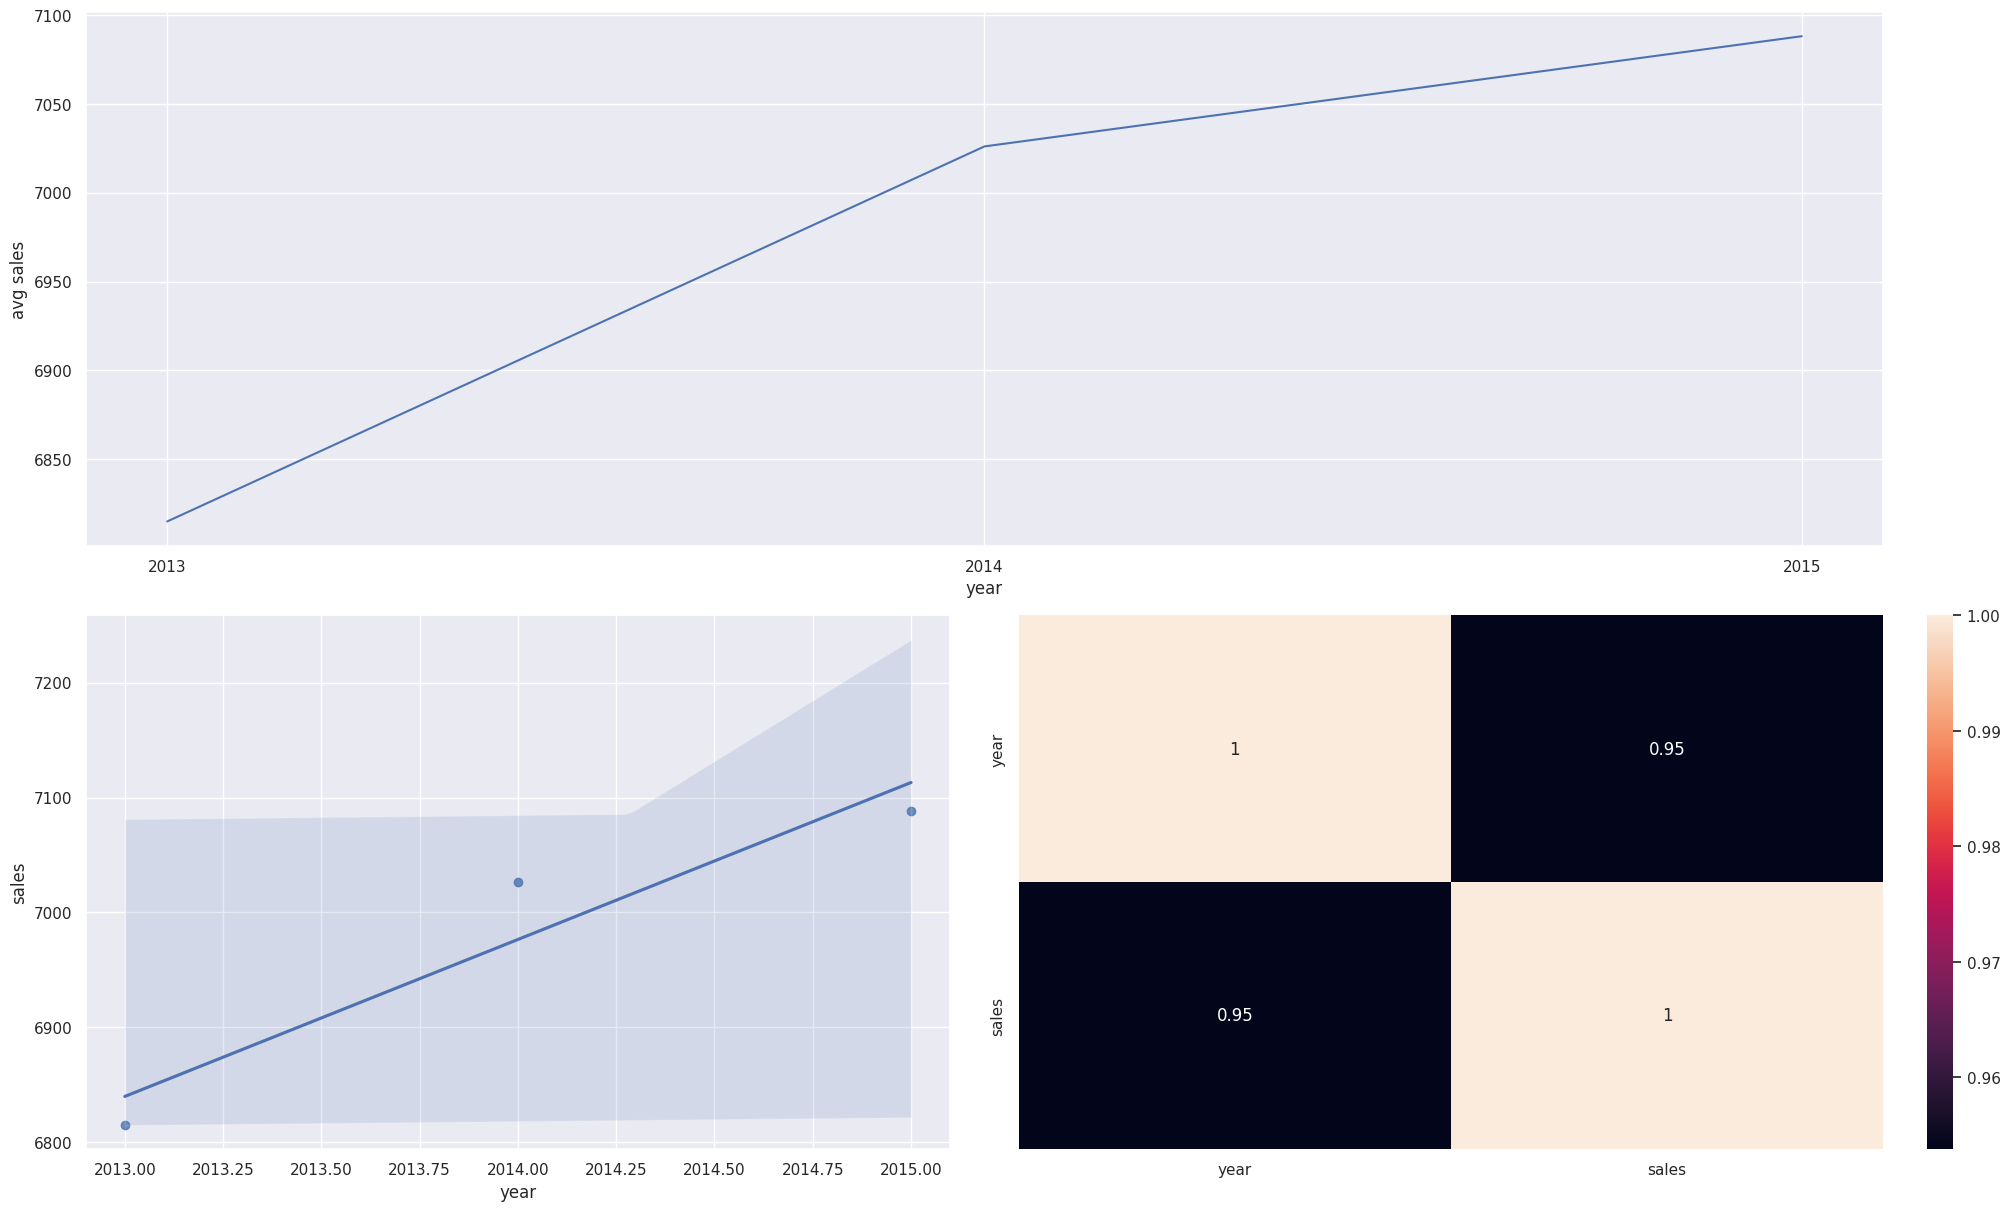

In [146]:
fig = plt.figure(figsize=(20,12), layout="constrained")
spec = fig.add_gridspec(2, 2)

#first graph
ax0 = fig.add_subplot(spec[0, :])
aux = df4[['year', 'sales']].groupby('year').mean().reset_index()
sns.lineplot(data=aux, x = 'year', y = 'sales', ax = ax0)
plt.ylabel('avg sales')
plt.xticks(np.arange(aux['year'].min(), aux['year'].max() + 1, 1))

#second graph
ax10 = fig.add_subplot(spec[1, 0])
sns.regplot(data=aux, x = 'year', y = 'sales', ax=ax10)

#third graph
ax11 = fig.add_subplot(spec[1, 1])
cor = aux.corr(method='pearson')
sns.heatmap(cor, annot=True, ax=ax11);

### H9. Lojas deveriam vender mais no segundo semestre do ano, em média.
***FALSO*** Não há tanta variação durante os meses dos ano, exceto em dezembro.

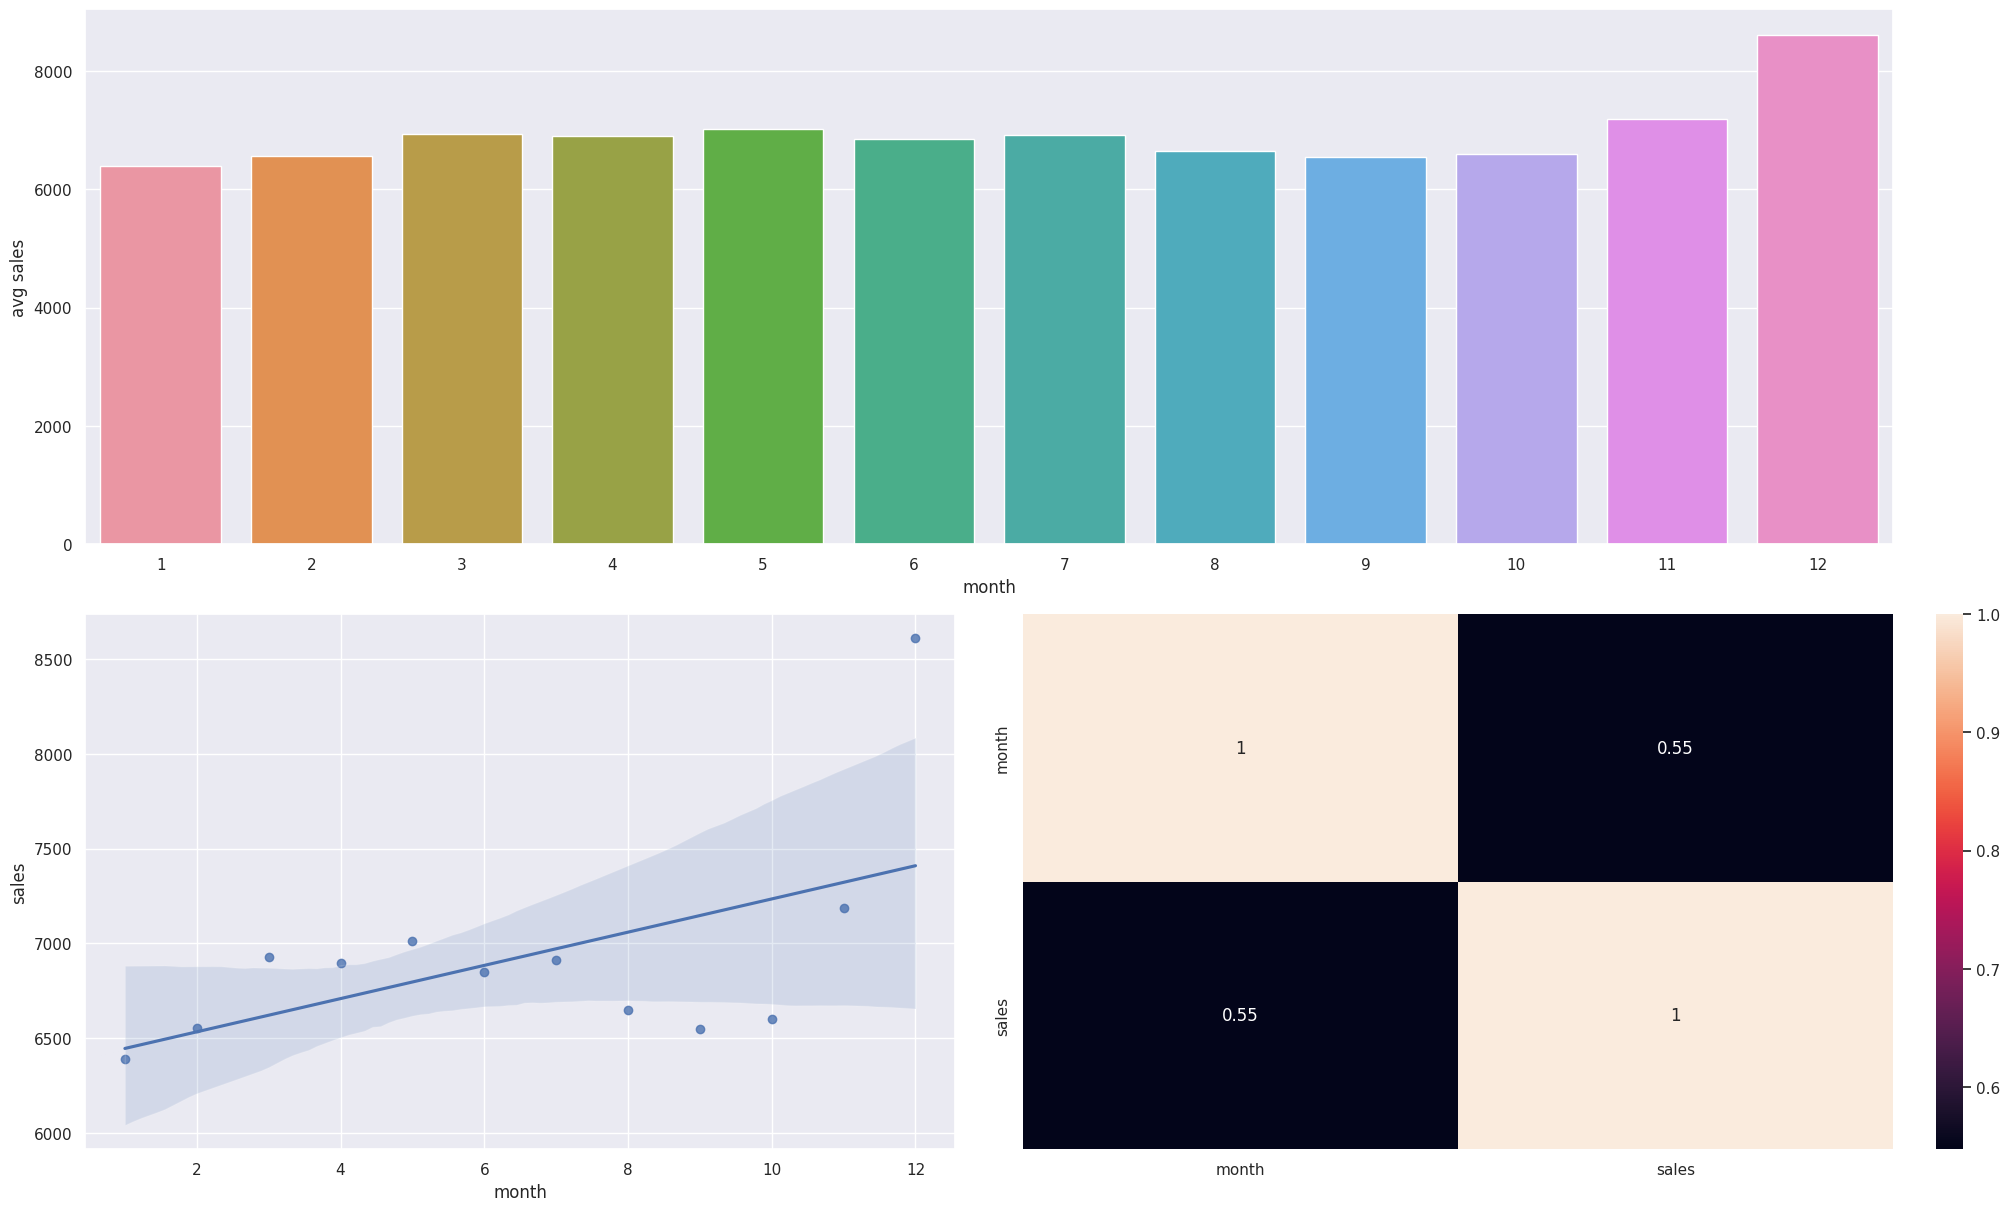

In [147]:
fig = plt.figure(figsize=(20,12), layout="constrained")
spec = fig.add_gridspec(2, 2)

#first graph
ax0 = fig.add_subplot(spec[0, :])
aux = df4[(df4['year'] != 2015)][['month', 'sales']].groupby('month').mean().reset_index()
sns.barplot(data=aux, x = 'month', y = 'sales', ax = ax0)
plt.ylabel('avg sales')

#second graph
ax10 = fig.add_subplot(spec[1, 0])
sns.regplot(data=aux, x = 'month', y = 'sales', ax=ax10)

#third graph
ax11 = fig.add_subplot(spec[1, 1])
cor = aux.corr(method='pearson')
sns.heatmap(cor, annot=True, ax=ax11);

### H10. Lojas deveriam vender mais depois do dia 15 de cada mês, em média.
***FALSO*** As vendas são bem similares antes e depois do dia 15

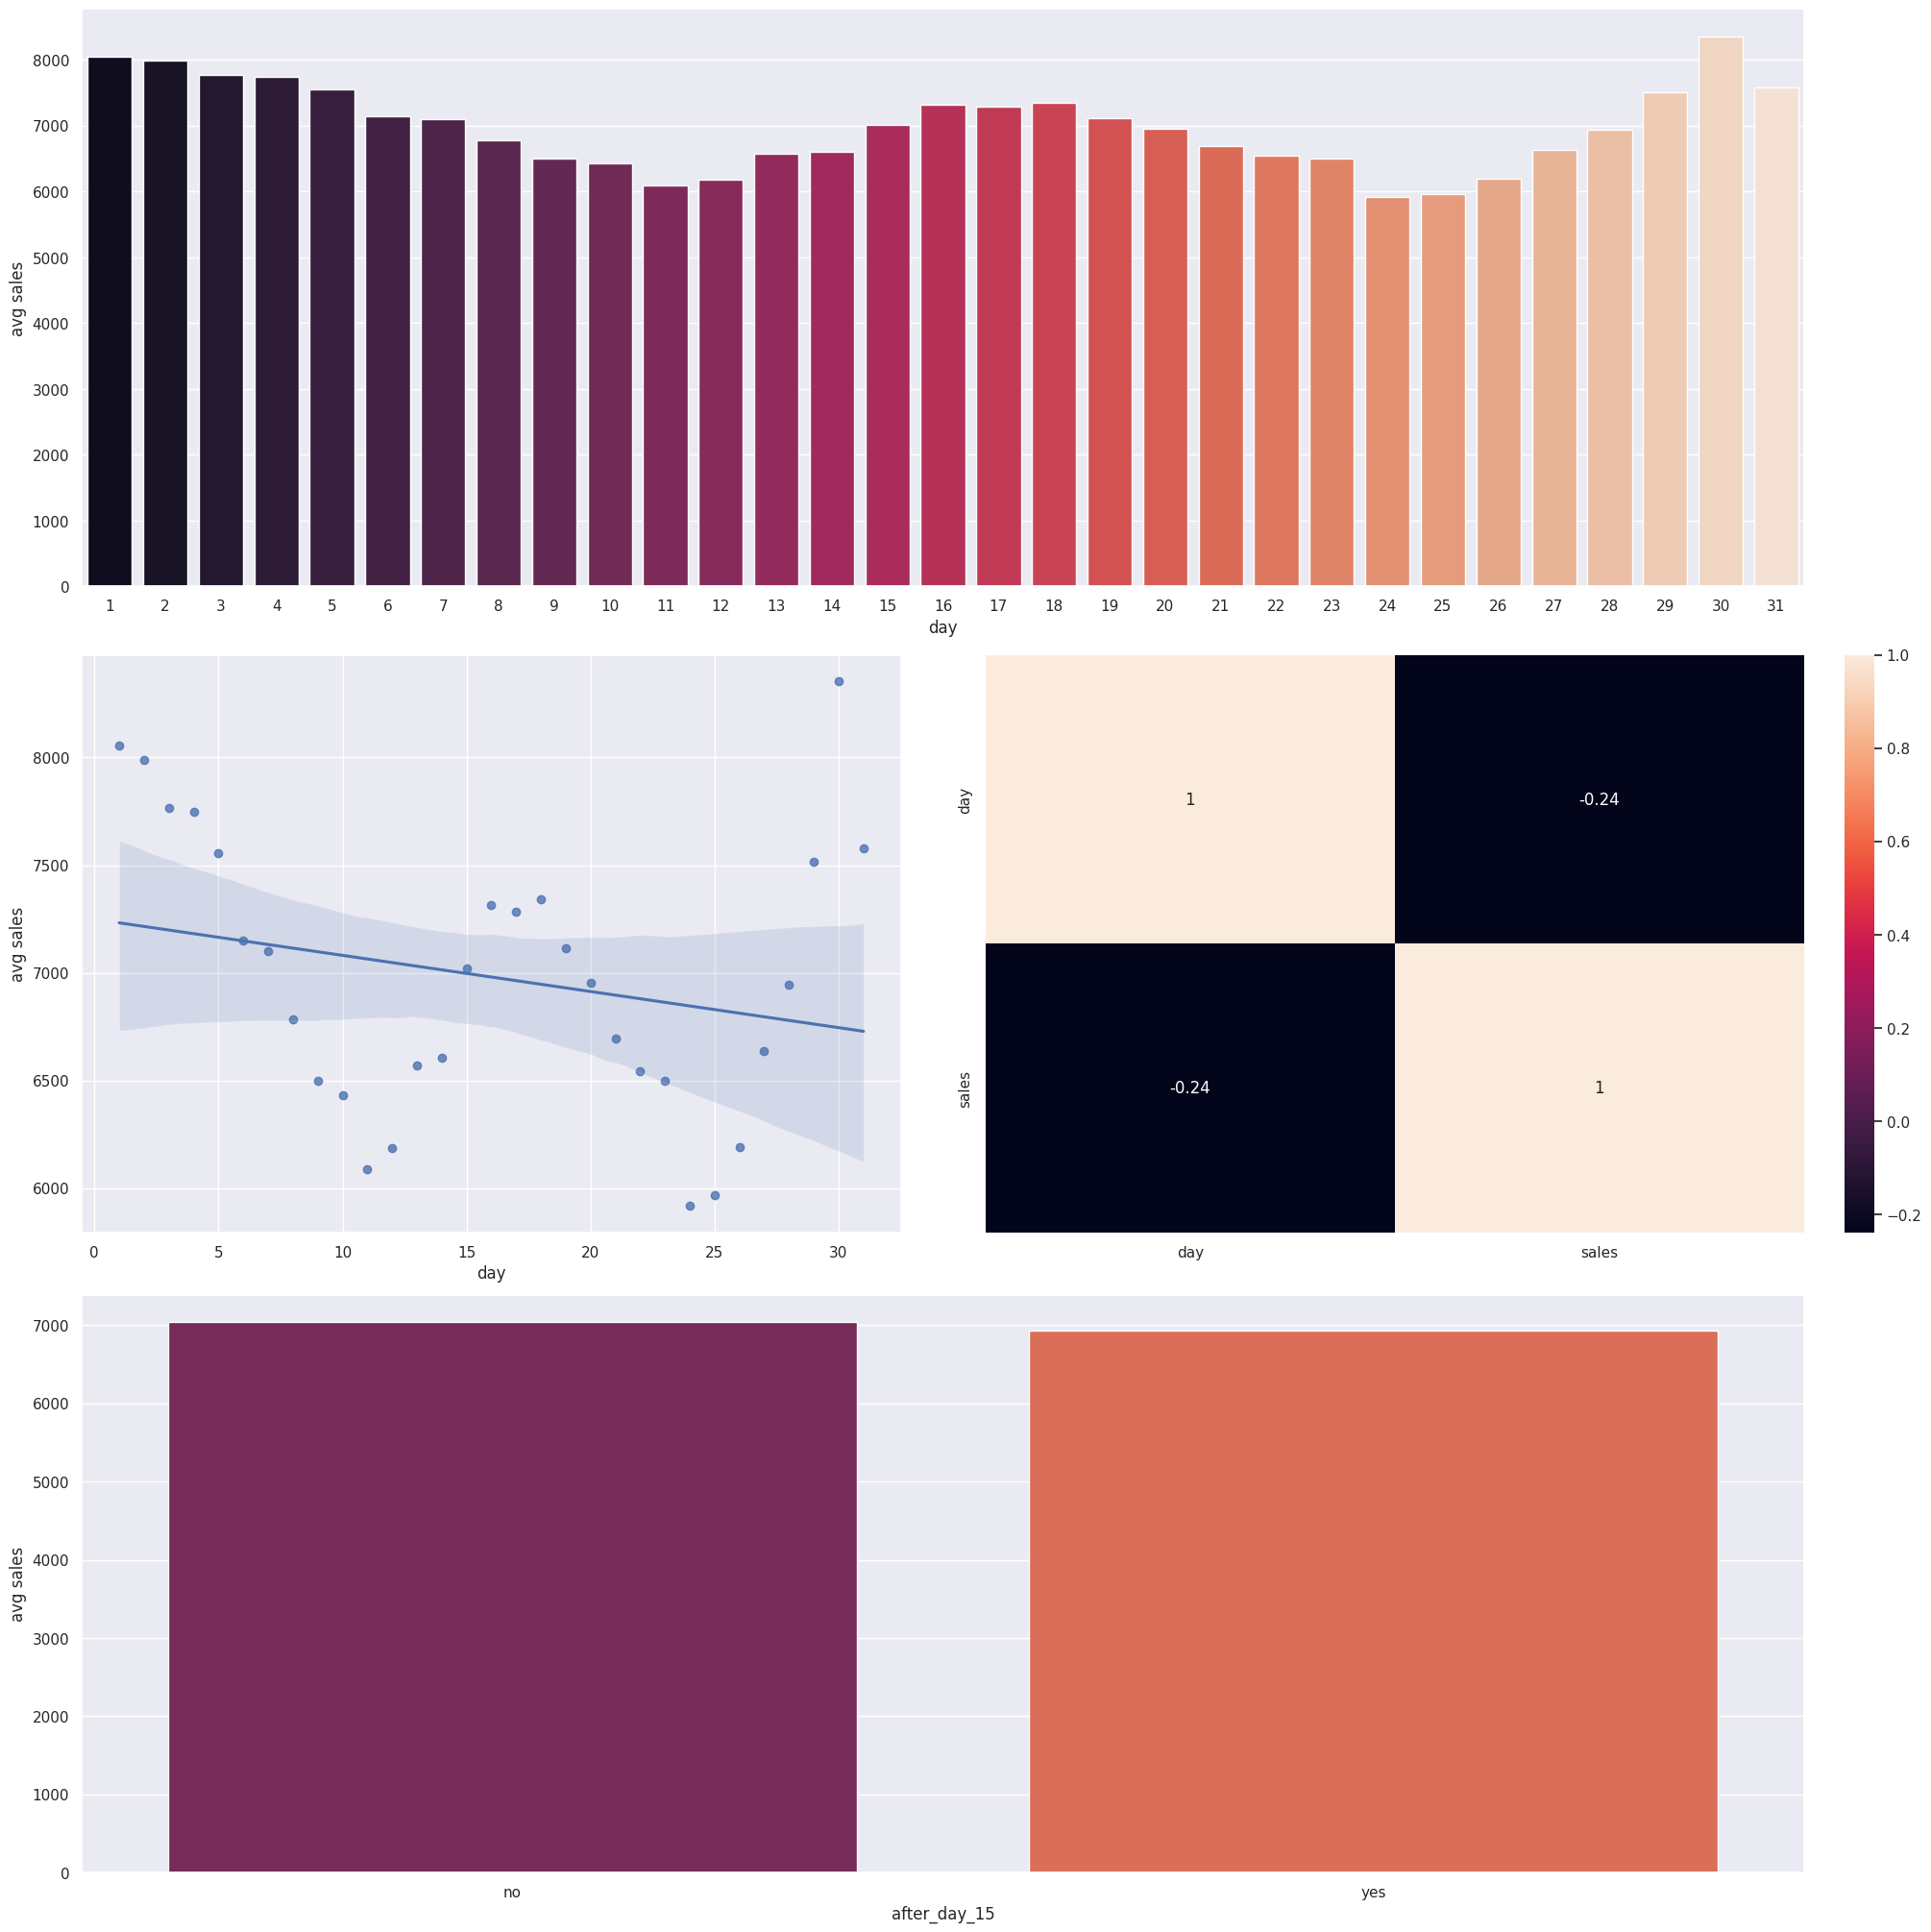

In [148]:
fig = plt.figure(figsize=(20,20), layout="constrained")
spec = fig.add_gridspec(3, 2)

#first graph
ax0 = fig.add_subplot(spec[0, :])
aux = df4[['day', 'sales']].groupby('day').mean().reset_index()
sns.barplot(data=aux, x = 'day', y = 'sales', ax = ax0, palette='rocket')
plt.ylabel('avg sales')

#second graph
ax10 = fig.add_subplot(spec[1, 0])
sns.regplot(data=aux, x = 'day', y = 'sales', ax=ax10)
plt.ylabel('avg sales')

#third graph
ax11 = fig.add_subplot(spec[1, 1])
cor = aux.corr(method='pearson')
sns.heatmap(cor, annot=True, ax=ax11);

#forth graph
aux['after_day_15'] = 'yes'
aux.loc[aux['day'] <= 15, 'after_day_15'] = 'no'
aux2 = aux.groupby('after_day_15').mean()['sales'].reset_index()

ax2 = fig.add_subplot(spec[2, :])
sns.barplot(data=aux2, x = 'after_day_15', y = 'sales', ax = ax2, palette='rocket')
plt.ylabel('avg sales');

### H11. Lojas deveriam vender menos aos finais de semana, em média.
***VERDADEIRO*** As vendem diminuem levemente durante o final de semana.

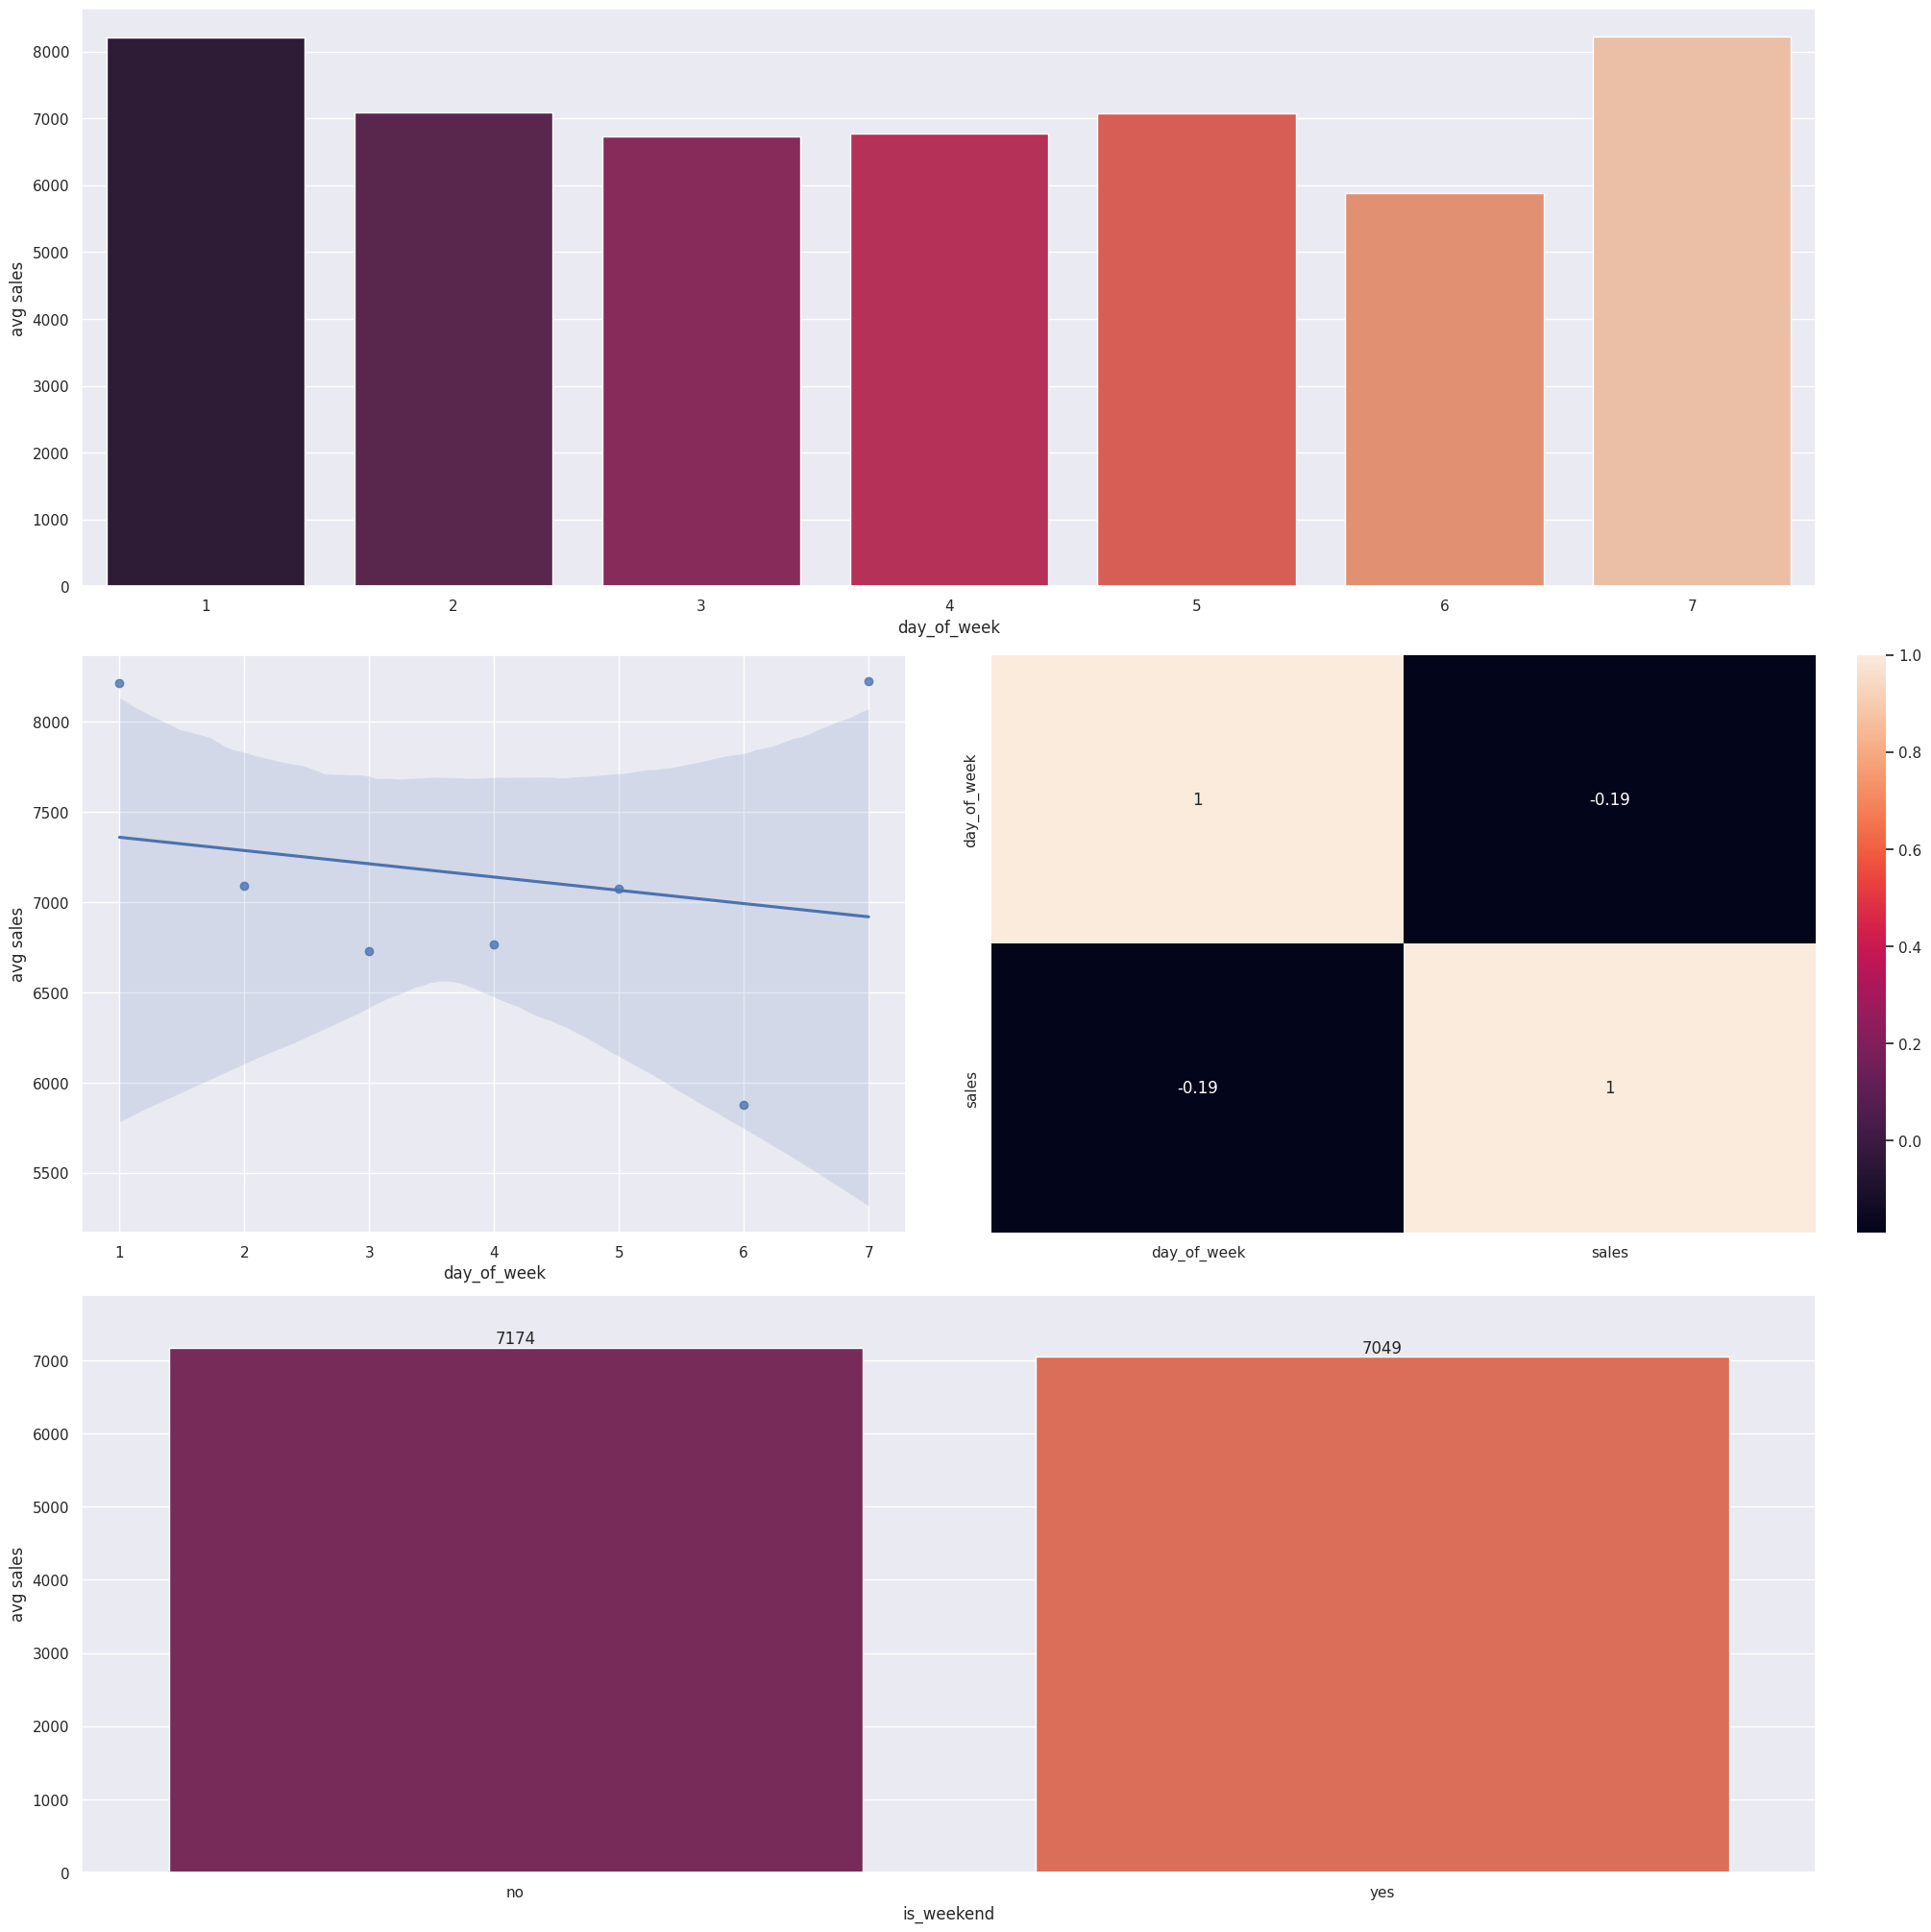

In [149]:
fig = plt.figure(figsize=(20,20), layout="constrained")
spec = fig.add_gridspec(3, 2)
sns.set(font_scale=1)

#fig 1
ax0 = fig.add_subplot(spec[0,:])
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()
sns.barplot(data = aux1, x = 'day_of_week', y='sales', palette='rocket')
plt.ylabel('avg sales')

#fig 2
ax10 = fig.add_subplot(spec[1, 0])
sns.regplot(data=aux1, x = 'day_of_week', y = 'sales', ax=ax10)
plt.ylabel('avg sales')

#fig 3
ax11 = fig.add_subplot(spec[1, 1])
cor = aux1.corr(method='pearson')
sns.heatmap(cor, annot=True, ax=ax11)

#fig 4
aux1['is_weekend'] = 'no'
aux1.loc[aux1['day_of_week'].isin([6,7]), 'is_weekend'] = 'yes'
aux2 = aux1.groupby('is_weekend').mean()['sales'].reset_index()

ax2 = fig.add_subplot(spec[2, :])
graph = sns.barplot(data=aux2, x = 'is_weekend', y = 'sales', ax = ax2, palette='rocket')

#adiciona label nas barras do último gráfico
graph.bar_label(graph.containers[0], label_type='edge', padding=0.2, fmt='%d')
graph.margins(y=0.1)

plt.ylabel('avg sales')
plt.show()

### H12. Lojas deveriam vender menos durante os feriados escolares, em média
***FALSO*** As lojas vendem mais durante os feriados escolares, em média!

<AxesSubplot: xlabel='month', ylabel='sales'>

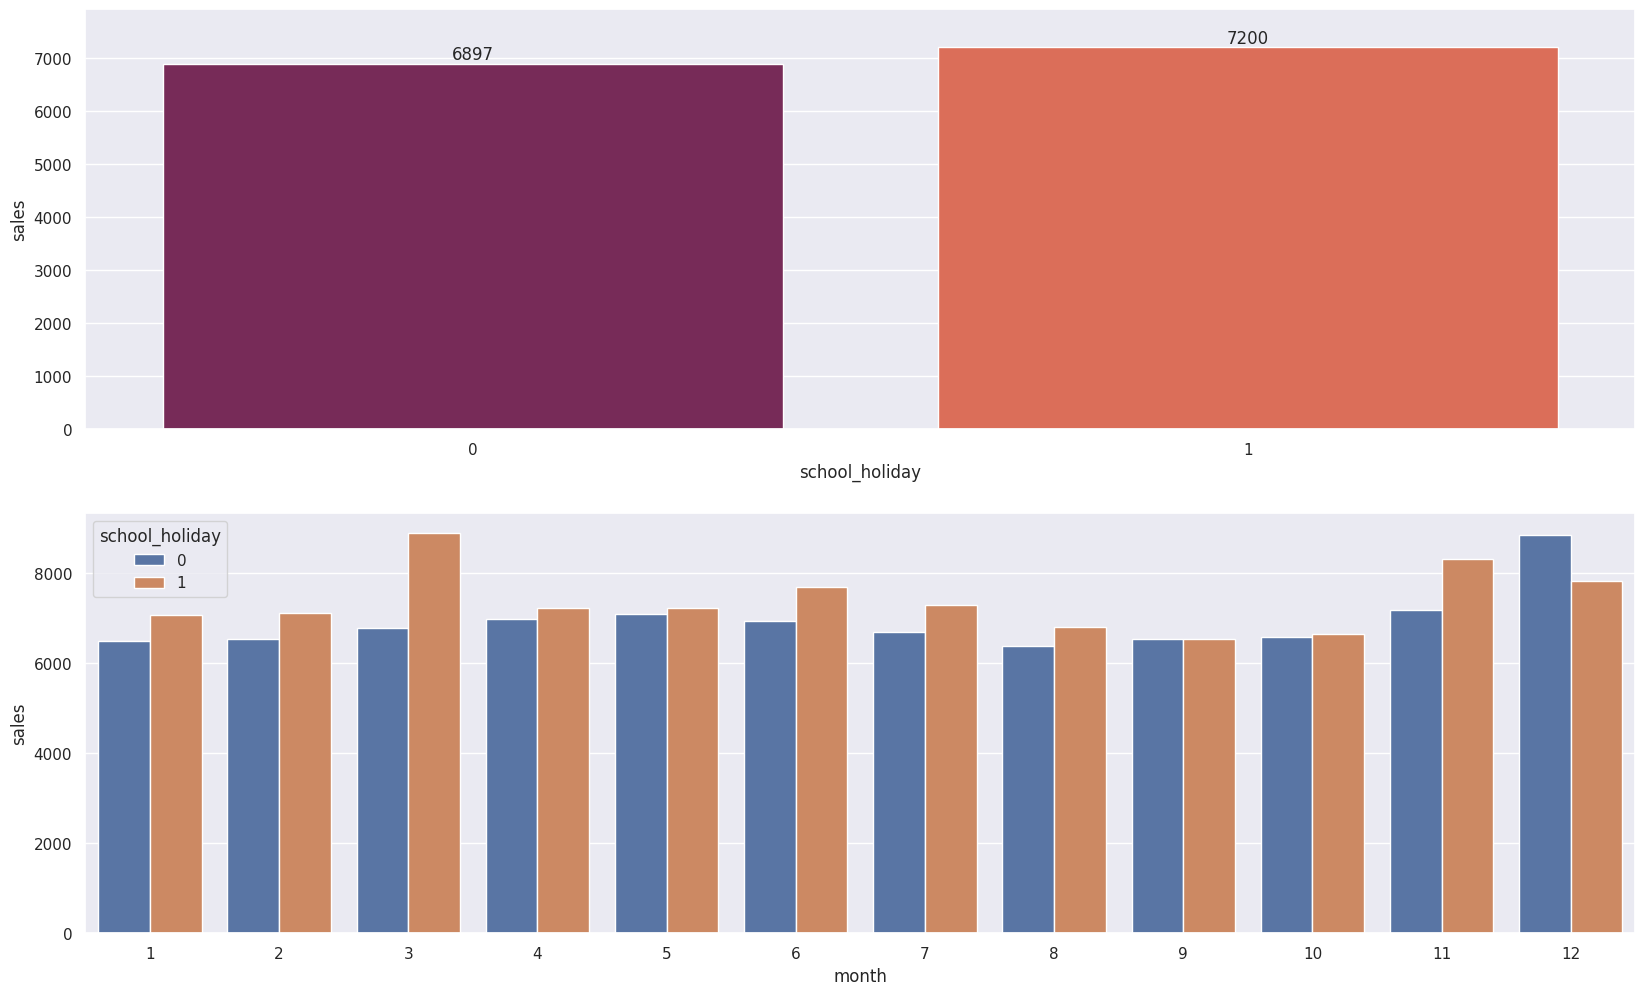

In [150]:
plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
graph = sns.barplot(data = aux1, x = 'school_holiday', y = 'sales', palette='rocket')

graph.bar_label(graph.containers[0], label_type='edge', padding=0.2, fmt='%d')
graph.margins(y=0.1)

plt.subplot(2,1,2)
aux2 = df4[['school_holiday', 'month', 'sales']].groupby(['month', 'school_holiday']).mean().reset_index()
sns.barplot(data=aux2, x = 'month', y = 'sales', hue='school_holiday')

## 4.3 Análise Multivariada

### 4.3.1. Atributos Numéricos

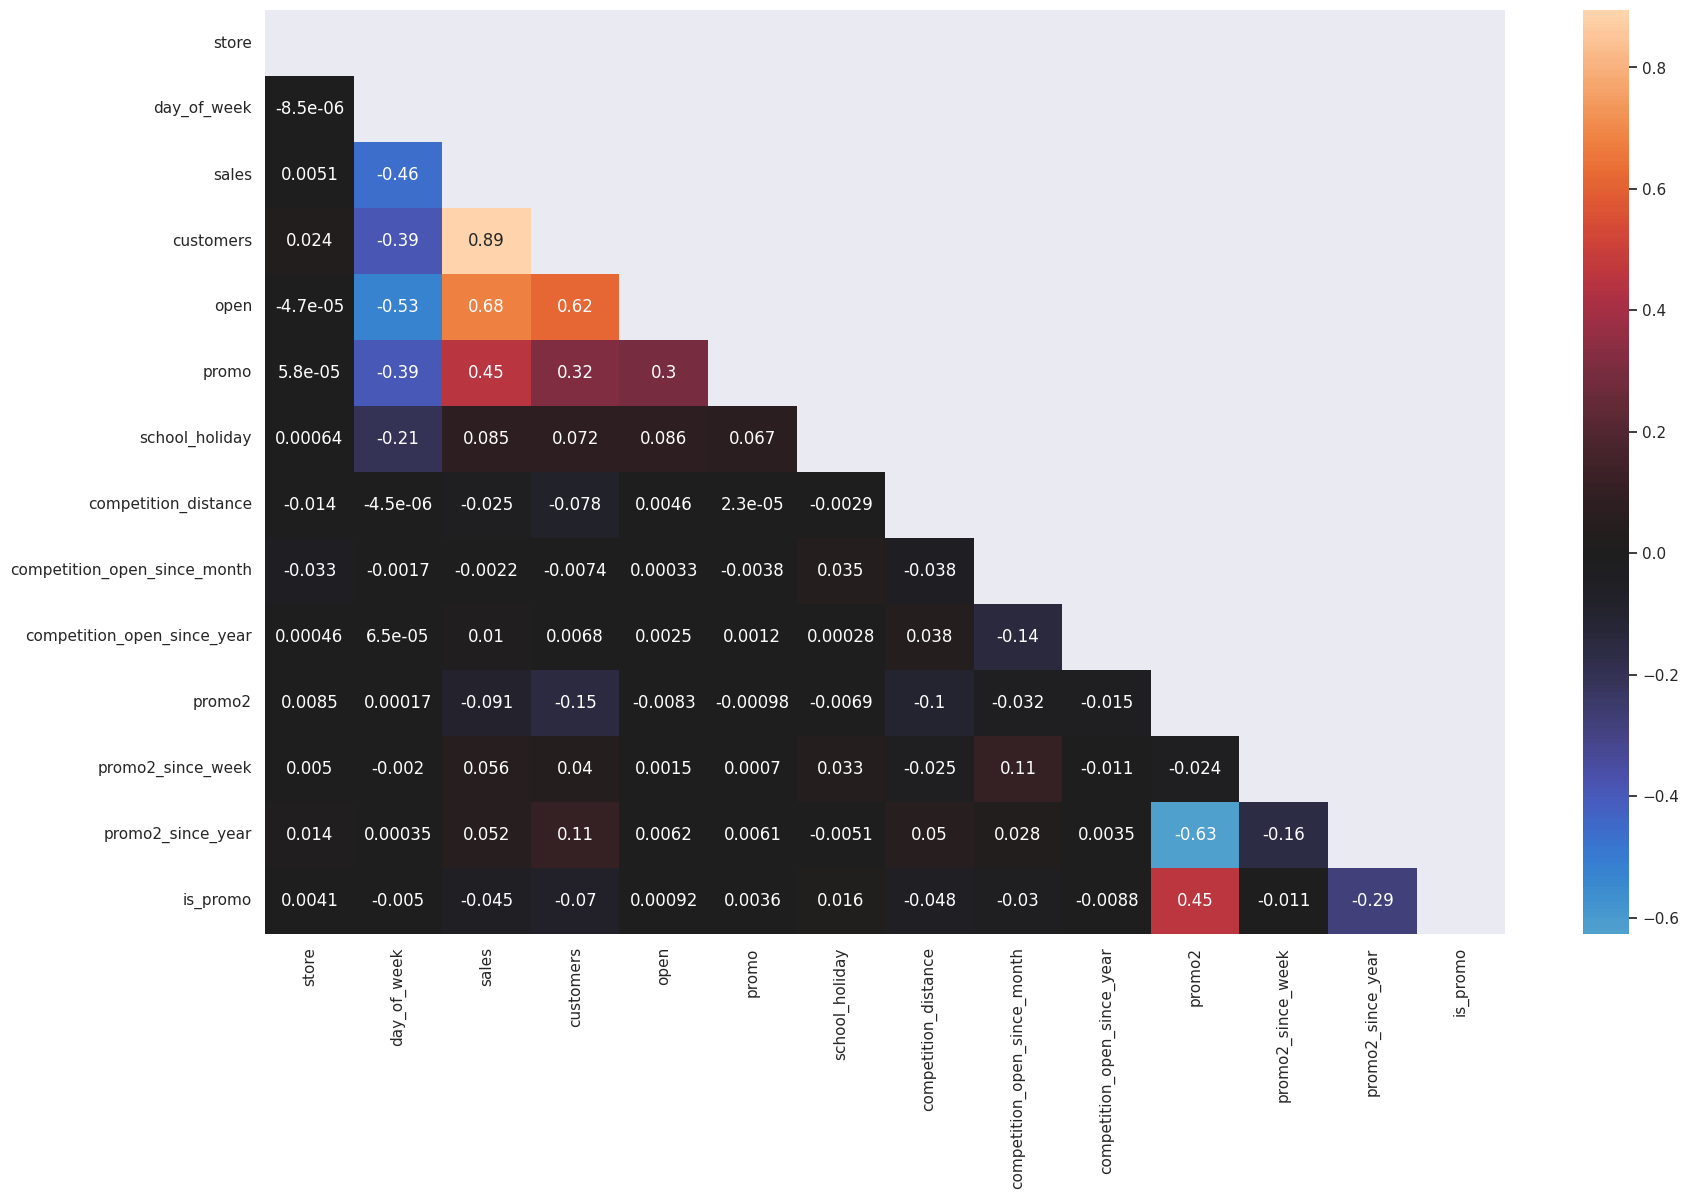

In [151]:
sns.set(font_scale=1)
plt.figure(figsize=(20,12))

corr = num_attributes.corr(method='pearson')
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, center=0);

### 4.3.2. Atributos Categóricos

In [152]:
cat_attributes = df4.select_dtypes(include='object')
cat_attributes.drop(columns=['year_week'], inplace=True)

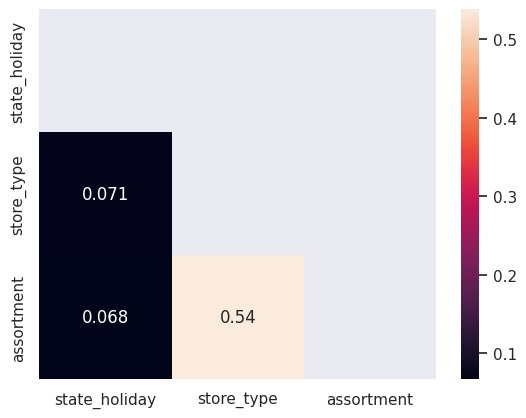

In [153]:
df_cramer = get_cramer_df(cat_attributes)

matrix = np.triu(df_cramer)
sns.heatmap(df_cramer, annot=True, mask=matrix);

# 5.0. PREPARACAO DE DADOS

In [154]:
df4.drop(columns=['competition_distance_binned', 'competition_time_month_binned'], inplace=True)
df5 = df4.copy()

## 5.1. Standardization (Z-Score Normalization)

Não iremos realizar pois não há variáveis com distribuição normal.

## 5.2. Normalization (Min-Max Scaling, RobustScaler)

In [155]:
num_attributes_df = df5.select_dtypes(include=['int64', 'float64'])

In [156]:
# VARIAVEIS NAO CICLICAS

rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# pickle.dump( rs, open( 'parameters/competition_distance_scaler.pkl', 'wb') )

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
# pickle.dump( rs, open( 'parameters/competition_time_month_scaler.pkl', 'wb') )

#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
# pickle.dump( mms, open( 'parameters/promo_time_week_scaler.pkl', 'wb') )

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
# pickle.dump( mms, open( 'parameters/year_scaler.pkl', 'wb') )

## 5.3. Transformacao

### 5.3.1. Encoding

In [157]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
# pickle.dump( le, open( 'parameters/store_type_scaler.pkl', 'wb') )

#assortment - Ordinal Encoding
assortment_dict = {'basic':1,
                   'extended': 2,
                   'extra': 3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Transformacao da variavel resposta

In [158]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Transformação de natureza

In [159]:
# VARIAVEIS CICLICAS

#day_of_week
df5['day_of_week_sin'] = np.sin(2 * np.pi * df5['day_of_week'] / df5['day_of_week'].max())
df5['day_of_week_cos'] = np.sin(2 * np.pi * df5['day_of_week'] / df5['day_of_week'].max())

#month
df5['month_sin'] = np.sin(2 * np.pi * df5['month'] / df5['month'].max())
df5['month_cos'] = np.cos(2 * np.pi * df5['month'] / df5['month'].max())

#day
df5['day_sin'] = np.sin(2 * np.pi * df5['day'] / df5['day'].max())
df5['day_cos'] = np.cos(2 * np.pi * df5['day'] / df5['day'].max())

#week_of_year
df5['week_of_year_sin'] = np.sin(2 * np.pi * df5['week_of_year'] / df5['week_of_year'].max())
df5['week_of_year_cos'] = np.cos(2 * np.pi * df5['week_of_year'] / df5['week_of_year'].max())


# 6.0. SELEÇÃO DE FEATURES

In [160]:
df6 = df5.copy()

## 6.1. Split dataset

In [161]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6.drop(columns=cols_drop, inplace=True)

In [162]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [163]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

In [164]:
X_train_fs = X_train.drop(columns = ['sales', 'date'])
X_test_fs = X_test.drop(columns = ['sales', 'date'])

## 6.2. Aplicando o Boruta

In [165]:
# model = xgb.XGBRegressor()

In [166]:
# fs = BorutaPy(model, n_estimators='auto', verbose=2, random_state=42)
# fs.fit(np.array(X_train_fs), np.array(y_train))

In [167]:
# print("Ranking: ",fs.ranking_)          
# print("No. of significant features: ", fs.n_features_)

In [168]:
# selected_features = pd.DataFrame({'Feature':list(X_train_fs.columns),
#                                   'Ranking':fs.ranking_})

# selected_features.sort_values(by='Ranking') 

In [169]:
# cols_selected = fs.support_.tolist()
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## 6.3. Selecao manual de features

In [170]:
cols_selected_boruta = ['store',
 'promo',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'is_promo',
 'year',
 'competition_time_month',
 'promo_time_week',
 'state_holiday_easter_holiday', #15
 'state_holiday_public_holiday', #16
 'state_holiday_regular_day', #17
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [171]:
# cols to add
add = ['date', 'sales']
cols_full = cols_selected_boruta + add

# 7.0. MODELING

In [172]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#training set with date and sales column
x_training = X_train[cols_full]

## 7.1. Average Model

In [173]:
aux1 = x_train.copy()
aux1['sales'] = y_train.copy()

#prediction
aux2 = aux1[['sales', 'store']].groupby('store').mean().reset_index().rename(columns={'sales':'store_sales_mean'})
aux1 = pd.merge(aux1, aux2, on='store')
y_hat = aux1['store_sales_mean']

#performance
result_av = ml_error('Average_model', np.expm1(y_train), np.expm1(y_hat))
result_av

,Model Name,MAE,MAPE,RMSE
0,Average_model,2874.648586,0.472426,3926.267517


## 7.2. Linear Regression

In [174]:
#model
model = LinearRegression()
model.fit(x_train, y_train)

#prediction
yhat_lr = model.predict(x_train)

#performance
result_lr = ml_error('Linear Regression', np.expm1(y_train), np.expm1(yhat_lr))
result_lr

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1968.089785,0.306347,2816.466851


### 7.2.1. Linear Regression - CV

In [175]:
model = LinearRegression()
lr_cr = cross_validation(x_training, model, 'Linear Regression', 6, cv = 5, verbose = False)

## 7.3. Linear Regression Regularized Model - LASSO

In [176]:
#model
model = Lasso()
model.fit(x_train, y_train)

#prediction
yhat_lasso = model.predict(x_train)

#performance
result_lasso = ml_error('LASSO', np.expm1(y_train), np.expm1(yhat_lasso))
result_lasso

,Model Name,MAE,MAPE,RMSE
0,LASSO,2241.762634,0.358098,3163.980886


### 7.3.1. LASSO - CV

In [177]:
model = Lasso()
lasso_cv = cross_validation(x_training, model, 'Lasso', 6, cv = 5, verbose = False)

## 7.4. Random Forest Regression

In [178]:
# #model
# model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
# model.fit(x_train, y_train)

# #prediction
# yhat_rf = model.predict(x_train)

# #performance
# result_rf = ml_error('Random Forest', np.expm1(y_train), np.expm1(yhat_rf))
# result_rf

### 7.4.1. Random Forest - CV

In [179]:
# model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
# rf_cv = cross_validation(x_training, model, 'Random Forest', 6, cv = 5, verbose = True)

## 7.5. XGBoost Regressor

In [180]:
#model
# model = xgb.XGBRegressor(objective = 'reg:squarederror',
#                               n_estimators=100,
#                               eta = 0.01,
#                               max_depth=10,
#                               subsample = 0.7,
#                               colsample_bytree = 0.9)
# model.fit(x_train, y_train)

# #prediction
# yhat_xgb = model.predict(x_train)

# #performance
# result_xgb = ml_error('XGBoost', np.expm1(y_train), np.expm1(yhat_xgb))
# result_xgb

## 7.5.1. XGBoost - CV

In [181]:
# model = xgb.XGBRegressor(objective = 'reg:squarederror',
#                               n_estimators=100,
#                               eta = 0.01,
#                               max_depth=10,
#                               subsample = 0.7,
#                               colsample_bytree = 0.9)

# xgb_cv = cross_validation(x_training, model, 'XGBoost', 6, cv = 5, verbose = False)

## 7.6. Comparacao entre modelos

### 7.6.1 Resultados Sem Cross Validation

In [182]:
# models_results = pd.concat([result_av, result_lasso, result_lr, result_rf, result_xgb]).sort_values('RMSE')
# models_results

### 7.6.2. Resultados Com Cross Validation

In [183]:
# models_results_cv = pd.concat([lr_cr, lasso_cv, rf_cv, xgb_cv]).sort_values('RMSE_mean')
# models_results_cv

# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [184]:
#set of parameters

param = {
    'n_estimators':[10, 50, 100, 200, 300],
    'eta':[0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5

In [185]:
#random search

# final_results = pd.DataFrame()
# all_params = []


# for i in range(MAX_EVAL):
    
#     #escolhe parametros aleatoriamente
#     hp = {k:np.random.choice(v) for k, v in param.items()}
#     print(hp)
#     all_params.append(hp)
    
#     #model
#     model = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta = hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample = hp['subsample'],
#                                   colsample_bytree = hp['colsample_bytree'],
#                                   min_child_weight = hp['min_child_weight'])

#     #performance
#     result = cross_validation(x_training, model, 'XGBoost', 6, cv = 5, verbose = False)
    
#     final_results = pd.concat([final_results, result])
    
# for i in sorted(zip(final_results['RMSE_mean'], final_results['RMSE_std'], par)):
#     print('\n',i)

## 8.2. Final Model - Evaluation on test set

In [186]:
param_tuned = {'n_estimators': 100, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}

In [187]:
#model
final_model = xgb.XGBRegressor( objective = 'reg:squarederror',
                                  n_estimators=param_tuned['n_estimators'],
                                  eta = param_tuned['eta'],
                                  max_depth=param_tuned['max_depth'],
                                  subsample = param_tuned['subsample'],
                                  colsample_bytree = param_tuned['colsample_bytree'],
                                  min_child_weight = param_tuned['min_child_weight'] )

final_model.fit(x_train, y_train)

#prediction

final_predictions = final_model.predict(x_test)

#performance

final_results = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(final_predictions))
final_results

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,2659.314148,0.327721,3564.898674


In [188]:
# pickle.dump(final_model, open('model/model_rossmann.pkl', 'wb'))

In [189]:
#mean percentage error
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(final_predictions))
mpe

0.2917210178653136

- De acorco com o MPE, nosso modelo está subestimando (muiiiito)

# 9.0. TRADUCAO E INTERPRETACAO DO ERRO

In [190]:
df9 = X_test[cols_full]

In [191]:
#rescale

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(final_predictions)

## 9.1. Business Performance

In [192]:
#sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

In [193]:
#MAE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})

#MAPE
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

In [194]:
#merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df9_aux3, df91, how='inner', on='store')

In [195]:
#cenarios

#best
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#worst
df92['worst_scenario'] = df92['predictions'] - df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [196]:
#highest MAPE
df92.sort_values(by='MAPE', ascending=False)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
841,842,175718.906250,160097.876900,191339.935600,15621.029350,0.763386
787,788,182346.640625,169615.711802,195077.569448,12730.928823,0.719153
697,698,180817.515625,168898.799897,192736.231353,11918.715728,0.707791
816,817,225469.546875,210703.642802,240235.450948,14765.904073,0.702373
261,262,278367.093750,263649.212505,293084.974995,14717.881245,0.684584
...,...,...,...,...,...,...
164,165,136800.265625,136463.466243,137137.065007,336.799382,0.081140
860,861,148613.031250,148344.284180,148881.778320,268.747070,0.076604
102,103,171758.578125,171410.070649,172107.085601,348.507476,0.075640
1048,1049,138124.296875,137828.922997,138419.670753,295.373878,0.072500


<AxesSubplot: xlabel='store', ylabel='MAPE'>

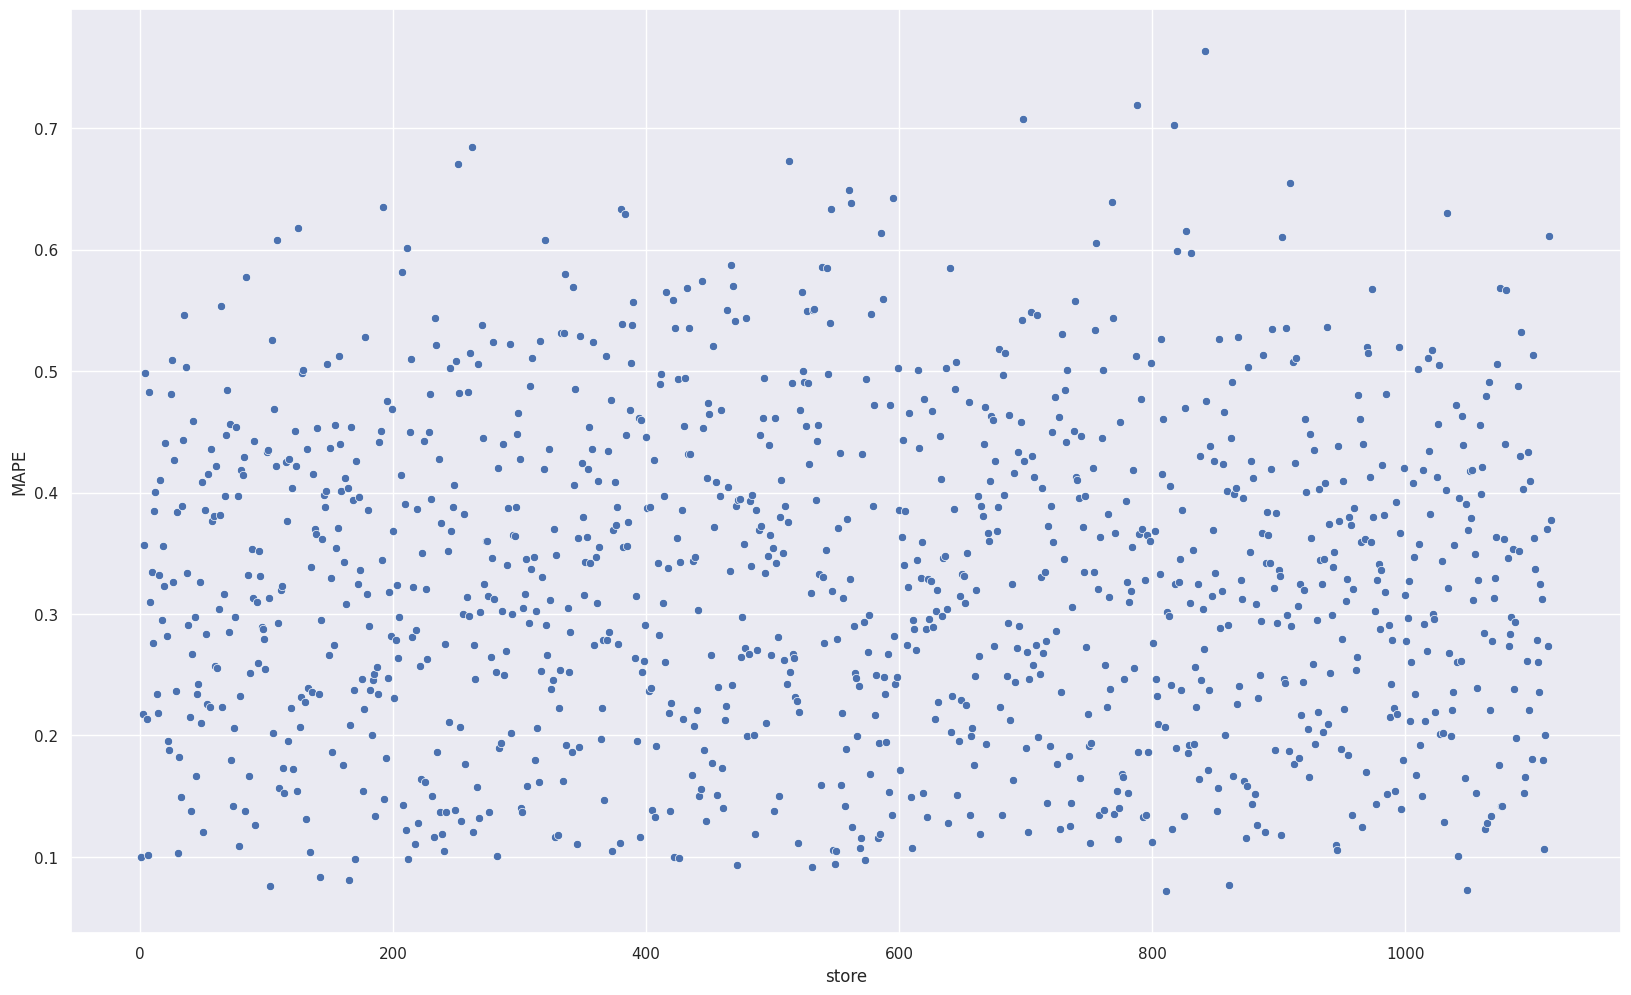

In [197]:
#scatter plot
plt.figure(figsize=(20,12))
sns.scatterplot(x = 'store', y = 'MAPE', data=df92)

## 9.2. Total Performance

In [198]:
values = {'prediction': df92['predictions'].sum(), 
          'worst_scenario': df92['worst_scenario'].sum(),
          'best_scenario': df92['best_scenario'].sum()}

total_perf = pd.DataFrame(pd.Series(data=values, index=list(values.keys()))).rename(columns = {0:'Values'})
total_perf.index.names = ['Scenarios']
total_perf['Values'] = total_perf['Values'].map('R${:,.2f}'.format)
total_perf

,Values
Scenarios,
prediction,"R$183,380,256.00"
worst_scenario,"R$180,419,702.25"
best_scenario,"R$186,340,812.00"


## 9.3. Machine Learning Perfomance


In [199]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

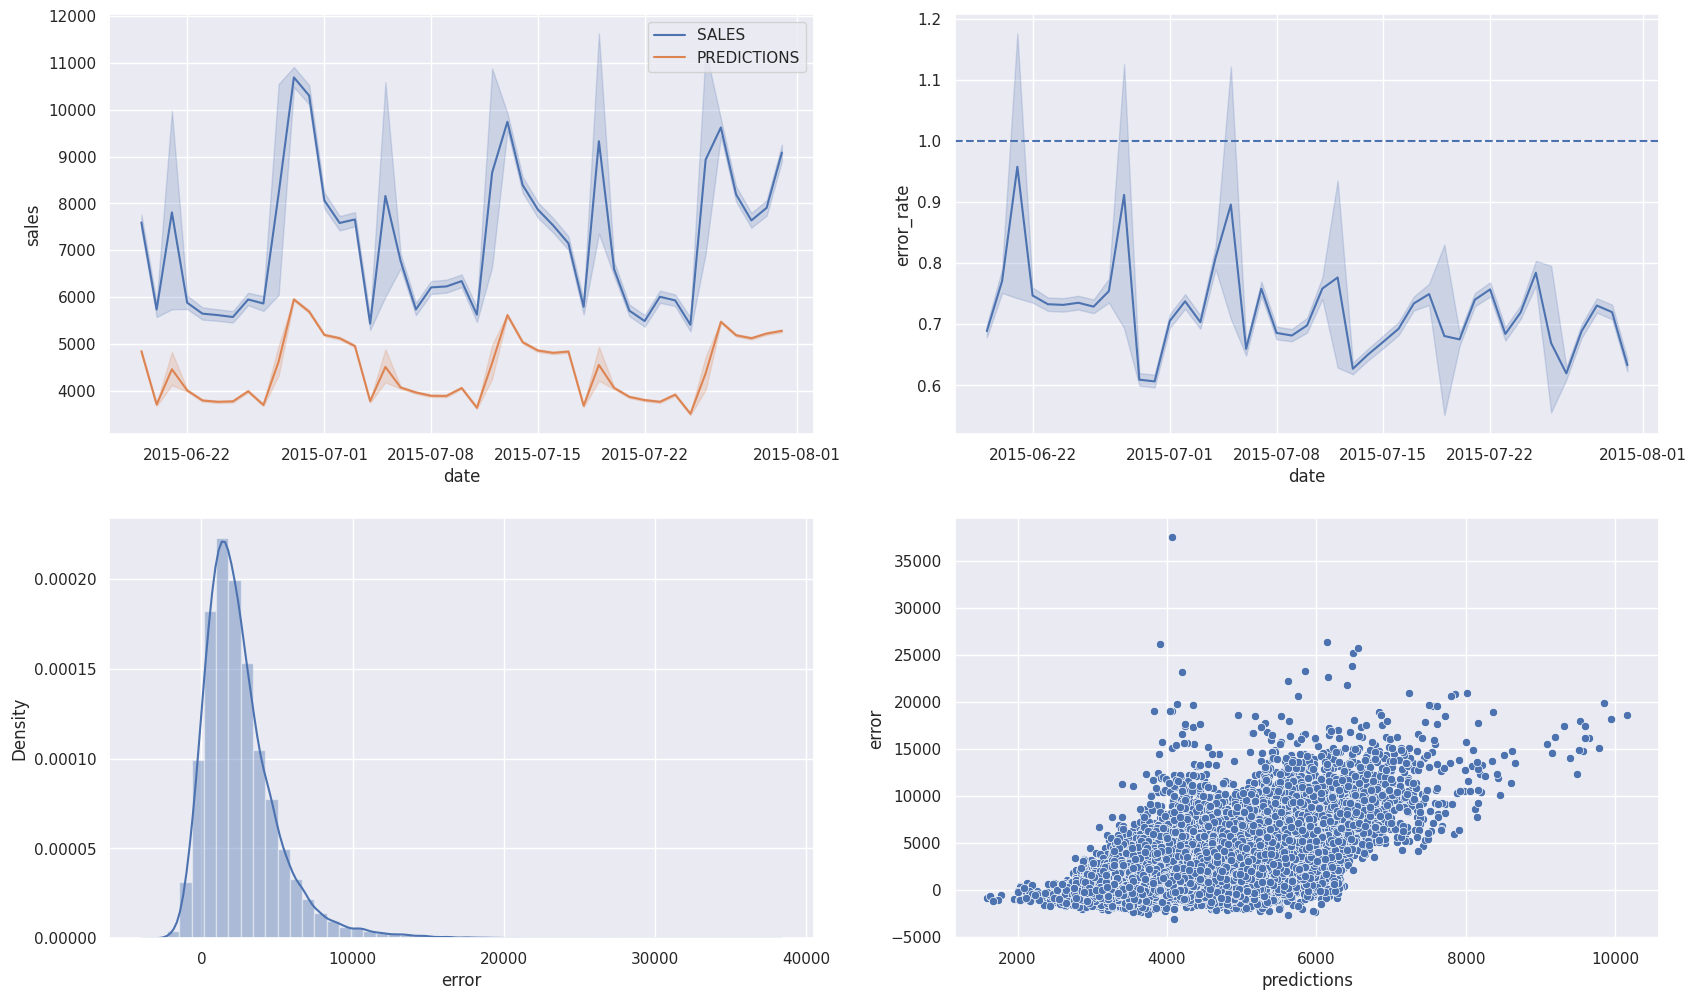

In [200]:
plt.figure(figsize=(20,12))

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x = 'predictions', y = 'error', data=df9);

# 10.0. DEPLOY MODEL TO PRODUCTION

In [201]:
#save model
pickle.dump(final_model, open('model/model_rossmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [202]:
import pickle
import inflection
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler = pickle.load(open( '/home/joao/Documentos/repos/rossmann_predict/parameters/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load(open( '/home/joao/Documentos/repos/rossmann_predict/parameters/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler = pickle.load(open( '/home/joao/Documentos/repos/rossmann_predict/parameters/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler = pickle.load(open( '/home/joao/Documentos/repos/rossmann_predict/parameters/year_scaler.pkl', 'rb') )
        self.store_type_scaler = pickle.load(open( '/home/joao/Documentos/repos/rossmann_predict/parameters/store_type_scaler.pkl', 'rb') )
    
    
    def data_cleaning(self, df1):
        

        #renomeia as colunas para snakecase
        cols = df1.columns.to_list()

        snakecase = lambda x: inflection.underscore(x)

        cols = list(map(snakecase, cols))

        #renomeia
        df1.columns = cols

        #converte coluna date para o tipo datetime
        df1['date'] = pd.to_datetime(df1['date'])


        ## 1.5. Preenche NAs

        # competition_distance
        df1.loc[df1['competition_distance'].isna() == True, 'competition_distance'] = 200000

        # competition_open_since_month
        df1.loc[df1['competition_open_since_month'].isna() == True, 'competition_open_since_month'] = df1['date'].dt.month

        # competition_open_since_year
        df1.loc[df1['competition_open_since_year'].isna() == True, 'competition_open_since_year'] = df1['date'].dt.year

        # promo2_since_week
        df1.loc[df1['promo2_since_week'].isna() == True, 'promo2_since_week'] = df1['date'].dt.isocalendar().week

        # promo2_since_year
        df1.loc[df1['promo2_since_year'].isna() == True, 'promo2_since_year'] = df1['date'].dt.year

        # promo_interval
        month_map = {1: 'Jan',
                     2: 'Feb',
                     3: 'Mar',
                     4: 'Apr',
                     5: 'May',
                     6: 'Jun',
                     7: 'Jul',
                     8: 'Aug',
                     9: 'Sept',
                     10: 'Oct',
                     11: 'Nov',
                     12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 or
                                                    x['month_map'] not in x['promo_interval'].split(',') else 1, axis=1)

        ## 1.6. Mudando tipo dos dados

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int')
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int')
        
        return df1
    
    
    def feature_engineering(self, df2):
        
        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.strftime('%U')
        df2['week_of_year'] = df2['week_of_year'].astype(int)

        #year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%U')

        #competition since
        df2['competition_since'] = df2.apply(lambda x : datetime(year = x['competition_open_since_year'],
                                                                 month = x['competition_open_since_month'],
                                                                 day=1), axis=1)

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        #assortment

        df2.loc[df2['assortment'] == 'a', 'assortment'] = 'basic'
        df2.loc[df2['assortment'] == 'b', 'assortment'] = 'extra'
        df2.loc[df2['assortment'] == 'c', 'assortment'] = 'extended'

        #state holiday

        df2.loc[df2['state_holiday'] == 'a', 'state_holiday'] = 'public_holiday'
        df2.loc[df2['state_holiday'] == 'b', 'state_holiday'] = 'easter_holiday'
        df2.loc[df2['state_holiday'] == 'c', 'state_holiday'] = 'christmas'
        df2.loc[df2['state_holiday'] == '0', 'state_holiday'] = 'regular_day'


        ## 3.1. Filtragem das linhas

        df2 = df2[(df2['open'] != 0)]

        ## 3.2. Filtragem das colunas

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(columns=cols_drop)
        
        return df2
    
    
    def data_preparation(self, df5):
    
        #competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)

        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)

        #promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        #year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)


        ### 5.3.1. Encoding
        #state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        #store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])

        #assortment - Ordinal Encoding
        assortment_dict = {'basic':1,
                           'extended': 2,
                           'extra': 3}

        df5['assortment'] = df5['assortment'].map(assortment_dict)


        ### 5.3.3. Transformação de natureza

        # VARIAVEIS CICLICAS

        #day_of_week
        df5['day_of_week_sin'] = np.sin(2 * np.pi * df5['day_of_week'] / df5['day_of_week'].max())
        df5['day_of_week_cos'] = np.sin(2 * np.pi * df5['day_of_week'] / df5['day_of_week'].max())

        #month
        df5['month_sin'] = np.sin(2 * np.pi * df5['month'] / df5['month'].max())
        df5['month_cos'] = np.cos(2 * np.pi * df5['month'] / df5['month'].max())

        #day
        df5['day_sin'] = np.sin(2 * np.pi * df5['day'] / df5['day'].max())
        df5['day_cos'] = np.cos(2 * np.pi * df5['day'] / df5['day'].max())

        #week_of_year
        df5['week_of_year_sin'] = np.sin(2 * np.pi * df5['week_of_year'] / df5['week_of_year'].max())
        df5['week_of_year_cos'] = np.cos(2 * np.pi * df5['week_of_year'] / df5['week_of_year'].max())
        
        
        cols_selected = ['store',
         'promo',
         'school_holiday',
         'store_type',
         'assortment',
         'competition_distance',
         'competition_open_since_month',
         'competition_open_since_year',
         'promo2',
         'promo2_since_week',
         'promo2_since_year',
         'is_promo',
         'year',
         'competition_time_month',
         'promo_time_week',
         'state_holiday_easter_holiday', #15
         'state_holiday_public_holiday', #16
         'state_holiday_regular_day', #17
         'day_of_week_sin',
         'day_of_week_cos',
         'month_sin',
         'month_cos',
         'day_sin',
         'day_cos',
         'week_of_year_sin',
         'week_of_year_cos']
        
        cols_holiday = ['state_holiday_easter_holiday',
                         'state_holiday_public_holiday',
                         'state_holiday_regular_day']
        
        for col in cols_holiday:
            pos = 15
            if col not in df5:
                df5.insert(pos, col, 0)
            pos +=1
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        #predictions
        pred = model.predict(test_data)
        
        #join pred into original data
        
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

## 10.2. API Handler

In [203]:
from flask import Flask, request, Response
import pickle
import pandas as pd
from rossmann.Rossmann import Rossmann

#load model
model = pickle.load(open('/home/joao/Documentos/repos/rossmann_predict/model/model_rossmann.pkl', 'rb'))

#inicial API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #ha dados
        
        if isinstance(test_json, dict): #verifica se é um dicionario (se tem apenas uma linha)
            test_raw = pd.DataFrame(test_json, index = [0])
            
        else: #contem mais de uma linha
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
            
            
        #instancia rossmann class
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
        
    else: #nao ha dados
        return Response('{}', status=200, mimetype = 'application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [204]:
import requests

In [210]:
df10 = pd.read_csv('/home/joao/Documentos/repos/rossmann_predict/data/test.csv')

In [215]:
#merge df + store df
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

#escolher loja para previsao
df_test = df_test[df_test['Store'] == 22]

#remove closed days
df_test = df_test[df_test['Open'] != 0]

df_test = df_test[~df_test['Open'].isnull()]

df_test = df_test.drop('Id', axis=1)

In [216]:
#convert dataframe to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [217]:
#API call

# url = 'http://0.0.0.0:5000/rossmann/predict'

url = 'https://rossmann-jv-test.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json'} 

data= data

r = requests.post( url, data = data, headers = header)
print('Status Code {}'.format(r.status_code) )

Status Code 200


In [218]:
#JSON TO DATAFRAME
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [219]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('The Store {} will sell R$ {:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'],
                                                                 d2.loc[i, 'prediction']))

The Store 22 will sell R$ 159,309.63 in the next 6 weeks
